<a href="https://colab.research.google.com/github/wiatrak2/generative_classifiers/blob/master/code/scribblelens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scribblelens

## Utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install -r /content/drive/My\ Drive/master_thesis/requirements-colab.txt

     |████████████████████████████████| 266kB 14.2MB/s 
     |████████████████████████████████| 194kB 34.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.2-cp36-cp36m-linux_x86_64.whl size=44209 sha256=dedea7409f584ab130de3bb081d281ef6ef6eef101916f9b654c3649b8792014
  Stored in directory: /root/.cache/pip/wheels/54/b7/c7/2ada654ee54483c9329871665aaf4a6056c3ce36f29cf66e67
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install /content/drive/My\ Drive/master_thesis/ml_monitor

Processing ./drive/My Drive/master_thesis/ml_monitor
  Created wheel for ml-monitor: filename=ml_monitor-0.0.1-cp36-none-any.whl size=11964 sha256=5d7eeedd187ff8d5fdf9b992d7743ed64030f29083ba367284092db833d42f36
  Stored in directory: /tmp/pip-ephem-wheel-cache-xfu7j3xx/wheels/06/7b/e3/1ff40ed93786c65f2e026b2e552f436790256f03ba5f87b4ed
  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=a82ea54344fc6ad2502d7daad2a33bf066828580029c043ffee4b86d1ab55496
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built ml-monitor gputil


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
import yaml
from collections import defaultdict, Counter

In [ ]:
#Add synchronized directory
#Remember to keep up to date on the local machine 
distsup_dir = "/content/drive/My Drive/DistSup"
import sys
sys.path.append(distsup_dir)

In [ ]:
from distsup import utils
from distsup.modules import reconstructors, encoders
from distsup.models import vqvae, minitest, representation_learners
from distsup.data import PaddedDatasetLoader, FixedDatasetLoader, ChunkedDataset
from egs.scribblelens.data import ScribbleLensDataset

In [ ]:
import ml_monitor

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
ml_monitor.colab.init()

## Classes

In [ ]:
class OneHotReconstructor(nn.Module):
  def __init__(self,
               embedding_dim,
               image_height=28,
               len_reduction=4,
               reconstructor={
                   'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                   'quantizer': {
                     'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                     'num_levels': 16
                    }
                   },
               device='cpu',
               ignore_alignment=False,
               count_blanks_alignment=True,
               advantage_digits=True,
               alignment_noise_pbb=None,
               **kwargs):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.image_height = image_height
    self.len_reduction = len_reduction
    cond_channels_spec = [{
        'cond_dim': embedding_dim,
        'reduction_factor': len_reduction
    }]
    rec_params = {
        'image_height': image_height,
        'cond_channels': cond_channels_spec
    }

    self.device = device
    if "class_name" in reconstructor:
      self.reconstructor = utils.construct_from_kwargs(reconstructor, additional_parameters=rec_params).to(device)
      self.reconstructors = {"": self.reconstructor}
    else:
      self.reconstructors = nn.ModuleDict({
          name: utils.construct_from_kwargs(rec, additional_parameters=rec_params).to(device)
          for name, rec in reconstructor.items()
      })
      self.reconstructor = next(iter(self.reconstructors.values()))

    self.ignore_alignment = ignore_alignment
    self.count_blanks_alignment = count_blanks_alignment
    self.advantage_digits = advantage_digits
    self.alignment_noise_pbb = alignment_noise_pbb
    self.mask = torch.ones(embedding_dim).long().to(device)
    if not self.count_blanks_alignment:
      self.mask[0] = 0
  
  def pad_batch(self, image_batch):
    padded_size = ((image_batch.size(1) + self.len_reduction - 1) // self.len_reduction) * self.len_reduction
    image_batch = F.pad(image_batch, [0, 0,
                          0, 0,
                          0, padded_size - image_batch.size(1)])
    assert image_batch.size(1) % self.len_reduction == 0
    return image_batch
  
  def transform_alignment(self, alignment, count_blanks=True):
    """
    Transforms the alignment description of the batch.
    Alignments are passed as padded tensor of size BS x AlignmentLen
    Each of BS padded alignments is a tensor with label of digit/letter in a column of pixels in corresponding image.
    This tensor (of lenght AlignmentLen) is transformed to a AlignmentLen x AlphabetSize matrix,
    where each label of digit/letter is transformed to one-hot vector (0 -> [1,0,0,0..], 1 -> [0,1,0,0..]).
    Then the matrix is reshaped to AlignmentLen x 1 x AlphabetSize tensor and reduced.
    The reduction has stride = self.len_reduction and is transforming len_rediction one-hot vectors to a vector
    representing the digit(s) placed in corresponding len_reduction pixel columns of the image.
    In used alphabets datasets the label `0` is assigned to "blank", but if `self.count_blanks_alignment` is False,
    the reduction transforms the following collumns of empty space to a vector of zeros ([1,0,0,0..] -> [0,0,0,0..]).
    If a digit occures within a len_reduction wide window, the reduction is assigning its one-hot vector to the transformed alignment,
    if `self.count_blanks_alignment` is True and some balnk columns also occures, the common label will be a combination of
    digit's and blank space one-hot vectors. if two digits occur within the window (unlikly), the reduction would make
    a logical or of their one-hot representation regardless of the `self.count_blanks_alignment` value
    (e.g. if there are digits '1' and '2' within the window, the reduction would produce [0,1,0,0,0..], [0,0,1,0,0..] -> [0,1,1,0,0..])
    """
    one_hot_alignment = F.one_hot(alignment, self.embedding_dim)
    bs, al_len, num_classes = one_hot_alignment.size()
    padded_alignment = self.pad_batch(one_hot_alignment.reshape(bs, al_len, 1, num_classes))
    reduced_al_len = padded_alignment.size(1) // self.len_reduction
    reduced_alignment = torch.empty((bs, reduced_al_len, 1, num_classes)).to(self.device)
    assert reduced_alignment.size(1) * self.len_reduction == padded_alignment.size(1)
    for i in range(0, al_len, self.len_reduction):
      reduced_idx = i // self.len_reduction
      reduced_alignment[:,reduced_idx,:,:] = torch.max(
          padded_alignment[:,i:i+self.len_reduction,:,:], dim=1).values * self.mask
      if not self.advantage_digits:
        mode_alignment = torch.mode(padded_alignment[:,i:i+self.len_reduction,:,:], dim=1).values
        if torch.sum(mode_alignment) > 0:
          reduced_alignment[:,reduced_idx,:,:] = mode_alignment
      if self.alignment_noise_pbb is not None:
        noise_idx = np.random.randint(0, self.embedding_dim)
        if np.random.rand() < self.alignment_noise_pbb:
          reduced_alignment[:,reduced_idx,:,noise_idx] = 1
    if self.ignore_alignment:
      return torch.zeros_like(reduced_alignment).to(self.device)
    return reduced_alignment

  def reconstruction_loss(self, batch):
    feats = batch['features'].to(self.device)
    labels = batch['alignment'].long().to(self.device)
    feats = self.pad_batch(feats)
    conds = self.transform_alignment(labels)
    
    losses = {}
    for name, reconstructor in self.reconstructors.items():
      inputs, targets = reconstructor.get_inputs_and_targets(feats)
      batch_rec = reconstructor(inputs, (conds,))
      loss = reconstructor.loss(batch_rec, targets)
      losses[name] = loss.mean()
    return losses


  def sample(self, labels, cut_blank=False, start_cond=None):
    self.reconstructor.eval()
    if cut_blank:
      digit_labels = torch.where(labels != 0)[0]
      digit_start, digit_end = digit_labels[0], digit_labels[-1]
      labels = labels[(digit_start - 5 * self.len_reduction):(digit_end + 5 * self.len_reduction)]
    labels = labels.to(self.device)
    sample_cond = self.transform_alignment(labels[None,:].long())
    cond_len = len(labels)
    sample_img = torch.zeros((1, cond_len, self.image_height, 1)).to(self.device)
    sample_img = self.pad_batch(sample_img)
    if start_cond is not None:
      start_img, start_step = start_cond
      start_img = self.pad_batch(start_img)
      return self.reconstructor.sample(start_img, (sample_cond,), start_step=start_step)
    return self.reconstructor.sample(sample_img, (sample_cond,))

  def forward(self, feats, labels=None):
    feats = self.pad_batch(feats)
    conds = (self.transform_alignment(labels),)
    if labels is None:
      conds = ()

    out = {}
    for rec_name, rec in self.reconstructors.items():
      inputs, _ = rec.get_inputs_and_targets(feats)
      rec_out = rec(inputs, conds)
      out[rec_name] = rec_out
    return out

In [ ]:
class ReconstructorTrainer:
  def __init__(self, model, data_loader,
               serialization_path=None,
               serialization_filename=None,
               serialize_epochs=None,
               serialize_sample=None):
    self.model = model
    self.data_loader = data_loader
    self.serialization_path = serialization_path or '/content/drive/My Drive/master_thesis/models/'
    self.serialization_filename = serialization_filename
    self.serialize_epochs = serialize_epochs
    self.serialize_sample = serialize_sample
    self.losses=[]

  def train(self, optimizer, epochs, scheduler=None):
    self.model.train()
    try:
      for epoch in range(1, epochs+1):
        for batch_idx, batch in enumerate(self.data_loader):
            
            optimizer.zero_grad()
            loss = self.model.reconstruction_loss(batch)

            batch_losses = []
            for rec, rec_loss in loss.items():
              batch_rec_loss = rec_loss.item()
              batch_losses.append(batch_rec_loss)
              ml_monitor.monitor(f"loss_{rec}", batch_rec_loss)

            loss = sum(loss.values())
            loss_value = loss.item()

            self.losses.append(tuple(batch_losses))
            self.losses.append(loss_value)

            loss.backward()
            optimizer.step()
            ml_monitor.monitor("loss", loss_value),
            ml_monitor.monitor("batch_num", batch_idx)
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * self.data_loader.batch_size, len(self.data_loader.dataset),
                    100. * batch_idx / len(self.data_loader),
                    loss_value))
                
        if scheduler:
          print('Applying LR scheduler...')
          scheduler.step()

        if self.serialize_epochs and epoch % self.serialize_epochs == 0:
          print('Serializing model...')
          self.serialize(epoch, optimizer)
      
    except KeyboardInterrupt:
      print('Interrupting...')
    return self.losses


  def serialize(self, epoch, optimizer):
    serialize_dict = {
        'model_state_dict': self.model.state_dict(),
        'optim_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'losses': self.losses,
    }
    if not self.serialization_filename:
      self.serialization_filename = type(self.model.reconstructor).__name__
    serialization_path = self.serialization_path + self.serialization_filename + datetime.datetime.now().strftime("_%Y-%m-%d_%H:%M:%S") + '.pkl'
    try:
      torch.save(serialize_dict, serialization_path)
    except Exception as e:
      print(f"Could not serialize model. Exception raised: {e}")
      return
    print(f'Model serialized as {serialization_path}')
    if self.serialize_sample is not None:
      generated_sample = self.model.sample(self.serialize_sample)
      sample_path = serialization_path.replace('.pkl', '.png')
      plt.imsave(sample_path, generated_sample.squeeze().data.cpu().transpose(0,1), cmap='gray')
      print(f'Sample image serialized as {sample_path}')

In [ ]:
num_classes = 68

### Pbb calculations

In [ ]:
class ImagePbbCalculator:

  def __init__(self, image, labels, alignment_rle, ignored_symbols=[]):
    if len(image.shape) == 3:
      # image should be 1 x W x H x 1
      image = image.unsqueeze(0)
    if len(labels.shape) == 1:
      # labels should be 1 x W
      labels = labels.unsqueeze(0)

    self.image = image.to(device)
    self.labels = labels.long().to(device)

    self.image_width = image.size(1)

    self.zero_img = torch.zeros_like(image).to(device)
    # get tuples (digit, start_pos, end_pos), where start_pos/end_pos are corresponding labels range
    self.digits_positions = [(labels[:,start.long()], start, end) for start, end in alignment_rle if start != end]

    self.ignored_symbols = ignored_symbols

  def is_position_ignored(self, position):
    return self.digits_positions[position][0] in self.ignored_symbols

  def compute_image_pbb(self, model, labels, pixels_range=None, reconstructors_weights=None):
    with torch.no_grad():
      # self.image is normalized to 0-1 range, we need integer value of pixels
      img_pixels_int = model.reconstructor.get_inputs_and_targets(self.image)[1]
      # if the main reconstructor is `RightToLeftReconstructor`, the target for the model is flipped. 
      if isinstance(model.reconstructor, reconstructors.RightToLeftReconstructor):
        img_pixels_int = torch.flip(img_pixels_int, dims=(1,))

      model_out = model(self.image, labels)
      if "rl" in model_out:
        model_out["rl"] = torch.flip(model_out["rl"], dims=(1,))

      if reconstructors_weights is not None:
        for rec_name in reconstructors_weights:
          if rec_name not in model_out:
            print(f"WARNING: {rec_name} in reconstructos_weights, but not in model's reconstructors.")
            continue
          model_out[rec_name] *= reconstructors_weights[rec_name]

      probs = {rec_name: F.log_softmax(model_out[rec_name].squeeze(), dim=-1) for rec_name in model_out}
      combined_out = sum(model_out.values())
      probabilities = sum(probs.values())
      unpadded_pbb = probabilities[:self.image_width]

      if pixels_range is not None:
        start, end = pixels_range
        img_pixels_int = img_pixels_int.squeeze()[start:end]
        unpadded_pbb = probabilities[start:end]

      # Reshape to 1D vector
      img_pixels_int_vec = img_pixels_int.reshape(-1)
      unpadded_pbb = unpadded_pbb.reshape(-1, probabilities.size(-1))
      image_pixels_pbb = unpadded_pbb[torch.arange(unpadded_pbb.size(0)), img_pixels_int_vec]
      return image_pixels_pbb, probabilities

  def test_model_labeling(self, model, digit_idx,
                          num_classes=num_classes,
                          replaced_digit_prob_only=False,
                          reconstructors_weights=None,
                          verbose=True):
    model.eval()
    testing_info = {}

    digit_idx = min(digit_idx, len(self.digits_positions) - 1)
    assert not self.is_position_ignored(digit_idx), f"Symbol at position {digit_idx} is set as ignored."
    digit, start, end = self.digits_positions[digit_idx]
    start, end = start.long(), end.long()
    max_log_prob = -np.inf
    best_digit = None
    labels_log_prob = torch.zeros(num_classes)
    if verbose:
      print(f'Digit with index {digit_idx}: {int(digit)}')
    for i in range(num_classes):
      new_label = i
      labels = self.labels.clone()
      labels[:,start:end] = new_label
      pixels_range = None if not replaced_digit_prob_only else (start,end)
      image_pixels_pbb, probs = self.compute_image_pbb(model, labels, pixels_range=pixels_range, reconstructors_weights=reconstructors_weights)
      log_prob = torch.sum(image_pixels_pbb)
      labels_log_prob[i] = log_prob
      testing_info[i] = {
          'image_log_pbb': log_prob,
          'image_pixels_pbb': image_pixels_pbb,
          'probabilities': probs,
          'labels': labels
      }
      if log_prob > max_log_prob:
        max_log_prob, best_digit = log_prob, i
      if verbose:
        print(f'After replecing {int(digit)} with {i} sum of image pixels log probabilities is {log_prob}')
    if verbose:
      print(f'Digit with highest probability ({max_log_prob}): {best_digit}')
    labels_prob = F.softmax(labels_log_prob, dim=-1)
    digit_prob_tuple = (digit.long(), labels_prob[digit.long()], labels_prob)
    return testing_info, digit_prob_tuple

  def plot_image_pixels_pbb(self, model, testing_info):
    img_pixels_int = model.reconstructor.get_inputs_and_targets(self.image)[1]
    for i in testing_info:
      print(f'Probabilities of orginal image pixels when labels are set as digit {i}:')
      pixels_score = testing_info[i]['probabilities'][:img_pixels_int.size(1),:,:]
      squeezed_pixels_score = pixels_score.view(-1, pixels_score.size(-1))
      image_log_pbb = squeezed_pixels_score[torch.arange(squeezed_pixels_score.size(0)), img_pixels_int.view(-1)]
      image_pbb = torch.exp(image_log_pbb.view(self.image_width,-1))

      plt.figure(figsize = (15,5))
      plt.imshow(1 - image_pbb.data.cpu().transpose(0,1), cmap='gray')
      plt.show()

In [ ]:
class ModelAlignmentCoincidentTester:
  def __init__(self, model, data_loader, ignored_symbols=[], reconstructors_weights=None):
    self.model = model
    self.data_loader = data_loader
    self.ignored_symbols = ignored_symbols
    self.reconstructors_weights = reconstructors_weights

    self.symbol_probs = []
    self.correctly_classified = []
    self.badly_classified = []
    self.all_samples = []

    self.ignored_classified = []

  def test_alignment_image_relation(self, samples_num): 
    ignored_symbols= []
    if len(self.ignored_symbols):
      ignored_symbols = [symbol_to_label[symbol] for symbol in ignored_symbols]

    for batch_idx, batch in enumerate(self.data_loader):
      batch_images_num = len(batch["features"])
      for i in range(batch_images_num):
        sample_test_img = batch['features'][i]
        sample_test_cond = batch['alignment'][i]
        sample_test_al_rle = batch['alignment_rle'][i]
        image_scorer = ImagePbbCalculator(sample_test_img, sample_test_cond, sample_test_al_rle, ignored_symbols=ignored_symbols)
        for i in range(len(image_scorer.digits_positions)):
          if image_scorer.is_position_ignored(i):
            continue
          labeling_info, labels_probs = image_scorer.test_model_labeling(self.model, i,reconstructors_weights=self.reconstructors_weights , verbose=False)
          symbol, symbol_pbb, all_pbb = labels_probs
          self.symbol_probs.append(symbol_pbb.item())
          
          classification_data = {
              'sample': sample_test_img,
              'symbol_pos': sample_test_al_rle[i],
              'symbol_idx': i,
              'symbol': symbol,
              'symbol_pbb': symbol_pbb,
              'all_pbb': all_pbb,
              'best_symbol': torch.argmax(all_pbb),
          }
          if torch.max(all_pbb) > symbol_pbb:
            self.badly_classified.append(classification_data)
          else:
            self.correctly_classified.append(classification_data)
          if len(self.symbol_probs) >= samples_num and samples_num > 0:
            self.all_samples = self.correctly_classified + self.badly_classified
            return
    self.all_samples = self.correctly_classified + self.badly_classified
    

  def ignore(self, symbol):
    if symbol not in self.ignored_symbols:
      self.ignored_symbols.append(symbol)
    
    for i, sample in enumerate(self.correctly_classified):
      if sample["symbol"].item() == symbol_to_label[symbol]:
        ignored_sample = self.correctly_classified.pop(i)
        self.ignored_classified.append(ignored_sample)

    for i, sample in enumerate(self.badly_classified):
      if sample["symbol"].item() == symbol_to_label[symbol]:
        ignored_sample = self.badly_classified.pop(i)
        self.ignored_classified.append(ignored_sample)
    
    self.all_samples = self.correctly_classified + self.badly_classified
    self.symbol_probs = [sample["symbol_pbb"].item() for sample in self.all_samples]
    

  def alignment_pbb_chart(self):
    w = np.ones(len(self.symbol_probs)) / len(self.symbol_probs) * 100
    plt.figure(figsize=(10,5))
    plt.ylabel("Percentage of samples")
    plt.xlabel("Probability of the true symbol")
    _ = plt.hist(self.symbol_probs, 25, weights=w)
    plt.show() 

  def top_pbb_chart(self):
    top_pbb = [torch.max(s["all_pbb"]) for s in self.all_samples]
    w = np.ones(len(top_pbb)) / len(top_pbb) * 100
    plt.figure(figsize=(10,5))
    plt.ylabel("Percentage of samples")
    plt.xlabel("Probability of the most likely symbol")
    _ = plt.hist(top_pbb, 25, weights=w)
    plt.show()     

  def show_badly_classified(self, samples_num=-1):
    for bad in self.badly_classified[:samples_num]:
      symbol = alphabet[bad['symbol'].item()]
      print(f"Symbol {symbol} at position {bad['symbol_idx']} was misclassified as {alphabet[bad['best_symbol'].item()]}.")
      print(f"Probability of the true symbol: {bad['symbol_pbb'].item()}. Probability of {alphabet[bad['best_symbol'].item()]}: {torch.max(bad['all_pbb'])}")
      plt.figure(figsize=(3, 3))
      fault_pos_start, fault_pos_end = bad["symbol_pos"]
      plt.imshow(bad['sample'][fault_pos_start:fault_pos_end].squeeze().data.cpu().transpose(0,1), cmap='gray')
      plt.show()

  def summary(self):
    print(f"Classified samples: {len(self.all_samples)}\
          \tClassified correctly: {len(self.correctly_classified)} ({len(self.correctly_classified)/len(self.all_samples):.2f}%)\
          \tMiscalssified: {len(self.badly_classified)} ({len(self.badly_classified)/len(self.all_samples):.2f}%)")
    print(f"Average probability assigned to the true symbol was: {np.mean(self.symbol_probs):.2f}")
    corr_symbol_pbb = np.mean([sample["symbol_pbb"].item() for sample in self.correctly_classified])
    print(f"Average probability assigned to the true symbol, when classified correctly was: {corr_symbol_pbb:.2f}")
    bad_symbol_pbb = np.mean([torch.max(sample["all_pbb"]) for sample in self.badly_classified])
    print(f"Average probability of most likely symbol while misclassifying was: {bad_symbol_pbb:.2f}")

    badly_class_symbols = Counter([alphabet[sample["symbol"].item()] for sample in self.badly_classified])
    correct_class_symbols = Counter([alphabet[sample["symbol"].item()] for sample in self.correctly_classified])
    print(f"Symbols classified correctly: {yaml.dump(correct_class_symbols)}\nSymbols classified badly: {yaml.dump(badly_class_symbols)}")
    
    symbol_probs = defaultdict(lambda:list())
    for sample in self.all_samples:
      symbol_probs[alphabet[sample["symbol"].item()]].append(sample["symbol_pbb"].item())
    for symbol in symbol_probs:
      print(f"When classifying symbol {symbol} it's avg probability was: {np.mean(symbol_probs[symbol])}")
    
    print("Histogram of probabilities assigned to the true symbol:")
    self.alignment_pbb_chart()
    print("Histogram of highest assgined probability while processing each of symbols:")
    self.top_pbb_chart()



## Load data

In [ ]:
!ln -s '/content/drive/My Drive/master_thesis/data/098a84e0a9bdecf8820210b27ff4eb.zip' "/content/scribblelens.corpus.v1.zip"
!ln -s '/content/drive/My Drive/master_thesis/data/9cb8e16871301dfc34faefd6b512df.zip' "/content/scribblelens.paths.1.4.zip"
scribblelens_path = "/content/scribblelens.corpus.v1.zip"
alignment_path = "/content/scribblelens.paths.1.4.zip"

In [ ]:
scribblelens_loader = PaddedDatasetLoader({'class_name': 'egs.scribblelens.data.ScribbleLensDataset',
                              'root': scribblelens_path,
                              'split': 'train',
                              'slice': 'tasman',
                              'alignment_root': alignment_path,
                              'vocabulary': distsup_dir + '/egs/scribblelens/tasman.alphabet.plus.space.mode5.json',
                              'transcript_mode': 5,
                              },
                             #varlen_fields=['features', 'text', 'alignment', 'alignment_rle'],
                             rename_dict={
                                 'image': 'features'
                             },
                             batch_size=16)

Alphabet constructed from /content/drive/My Drive/DistSup/egs/scribblelens/tasman.alphabet.plus.space.mode5.json size= 68
ScribbleLensDataset()  datafile: scribblelens.corpus.v1/corpora/nl.bw.lines.tasman.train.dat and alphabet sizes before and after reading are 68 and 68


In [ ]:
sample_batch = next(iter(scribblelens_loader))

In [ ]:
with open(distsup_dir + '/egs/scribblelens/tasman.alphabet.plus.space.mode5.json') as f:
  symbol_to_label = json.load(f)
alphabet = {symbol_to_label[k]: k for k in symbol_to_label}

In [ ]:
sample_img = sample_batch['features'][0]
sample_cond = sample_batch['alignment'][0]
sample_rle = sample_batch['alignment_rle'][0]

In [ ]:
sample_batch.keys()

dict_keys(['item_dir', 'scribe', 'page', 'page_side', 'line_index', 'img_filename', 'scribe_id', 'alignment', 'alignment_len', 'alignment_text', 'alignment_rle', 'text_filename', 'img_size', 'features', 'features_len', 'text', 'text_available'])

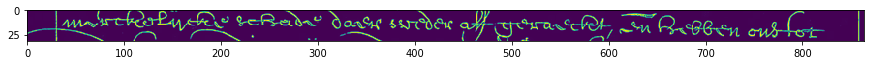

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(sample_batch['features'][0].squeeze().transpose(0,1))

In [ ]:
sample_batch['features'][0].size(0) == sample_batch['alignment'][0].size(0)

True

In [ ]:
len(scribblelens_loader.dataset)

963

In [ ]:
scribblelens_test_loader = PaddedDatasetLoader({'class_name': 'egs.scribblelens.data.ScribbleLensDataset',
                              'root': scribblelens_path,
                              'split': 'test',
                              'slice': 'tasman',
                              'alignment_root': alignment_path,
                              'vocabulary': distsup_dir + '/egs/scribblelens/tasman.alphabet.plus.space.mode5.json',
                              'transcript_mode': 5,
                              },
                             #varlen_fields=['features', 'text', 'alignment', 'alignment_rle'],
                             rename_dict={
                                 'image': 'features'
                             },
                             batch_size=16)

Alphabet constructed from /content/drive/My Drive/DistSup/egs/scribblelens/tasman.alphabet.plus.space.mode5.json size= 68
ScribbleLensDataset()  datafile: scribblelens.corpus.v1/corpora/nl.bw.lines.tasman.test.dat and alphabet sizes before and after reading are 68 and 68


In [ ]:
sample_test_batch = next(iter(scribblelens_test_loader))

In [ ]:
sample_test_img = sample_test_batch['features'][0]
sample_test_cond = sample_test_batch['alignment'][0]
sample_test_rle = sample_test_batch['alignment_rle'][0]

In [ ]:
chunked_tasman_dataset = ChunkedDataset(
    dataset=ScribbleLensDataset(
        root=scribblelens_path,
        split="train",
        slice="tasman",
        vocabulary= distsup_dir + '/egs/scribblelens/tasman.alphabet.plus.space.mode5.json',
        alignment_root = alignment_path,
        transcript_mode=5),
    chunk_len=96,
    oversample=4,
    training=True,
    varlen_fields = ['image', 'alignment'],
    drop_fields = ['text', 'alignment_rle', 'page_side', 'page'])

Alphabet constructed from /content/drive/My Drive/DistSup/egs/scribblelens/tasman.alphabet.plus.space.mode5.json size= 68
ScribbleLensDataset()  datafile: scribblelens.corpus.v1/corpora/nl.bw.lines.tasman.train.dat and alphabet sizes before and after reading are 68 and 68


In [ ]:
chunked_tasman_loader = FixedDatasetLoader(dataset=chunked_tasman_dataset, batch_size=32, rename_dict={"image": "features"}, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
len(chunked_tasman_dataset)

3852

## Pixel CNN

In [ ]:
pixelcnn_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_PixelCNN_2019-12-17_15:24:47.pkl'
checkpoint = torch.load(model_serialize_path)
pixelcnn_rec.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
checkpoint["epoch"]

90

In [ ]:
pixelcnn_rec_trainer = ReconstructorTrainer(pixelcnn_rec, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_PixelCNN",
               serialize_epochs=100,
               serialize_sample=None)

In [ ]:
pixelcnn_rec_optim = optim.Adam(pixelcnn_rec.parameters(), lr=1e-3)
optim_scheduler = optim.lr_scheduler.StepLR(pixelcnn_rec_optim, step_size=75, gamma=0.1)

In [ ]:
pixelcnn_rec_losses = pixelcnn_rec_trainer.train(pixelcnn_rec_optim, 100, optim_scheduler)

Train Epoch: 1 [0/3852 (0%)]	Loss: 2.584493
Train Epoch: 1 [3200/3852 (83%)]	Loss: 0.688974
Applying LR scheduler...
Train Epoch: 2 [0/3852 (0%)]	Loss: 0.679913
Train Epoch: 2 [3200/3852 (83%)]	Loss: 0.560286
Applying LR scheduler...
Train Epoch: 3 [0/3852 (0%)]	Loss: 0.528673
Train Epoch: 3 [3200/3852 (83%)]	Loss: 0.526824
Applying LR scheduler...
Train Epoch: 4 [0/3852 (0%)]	Loss: 0.523110
Train Epoch: 4 [3200/3852 (83%)]	Loss: 0.532770
Applying LR scheduler...
Train Epoch: 5 [0/3852 (0%)]	Loss: 0.516268
Train Epoch: 5 [3200/3852 (83%)]	Loss: 0.473831
Applying LR scheduler...
Train Epoch: 6 [0/3852 (0%)]	Loss: 0.521397
Train Epoch: 6 [3200/3852 (83%)]	Loss: 0.456093
Applying LR scheduler...
Train Epoch: 7 [0/3852 (0%)]	Loss: 0.421417
Train Epoch: 7 [3200/3852 (83%)]	Loss: 0.470731
Applying LR scheduler...
Train Epoch: 8 [0/3852 (0%)]	Loss: 0.453702
Train Epoch: 8 [3200/3852 (83%)]	Loss: 0.455292
Applying LR scheduler...
Train Epoch: 9 [0/3852 (0%)]	Loss: 0.476911
Train Epoch: 9 [3200

In [ ]:
pixelcnn_rec_trainer.serialize(90, pixelcnn_rec_optim)

Model serialized as /content/drive/My Drive/master_thesis/models/Scribblelens_PixelCNN_2019-12-17_15:24:47.pkl


In [ ]:
image_scorer = ImagePbbCalculator(sample_img, sample_cond, sample_rle)

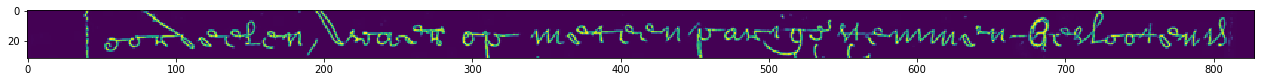

In [ ]:
plt.figure(figsize=(22,22))
plt.imshow(sample_img.squeeze().transpose(0,1))

In [ ]:
sample_test_batch['alignment_text'][0]

'oordeelen Waerop met eenparige stemmen beslooten is'

In [ ]:
digit_img = sample_img.clone()
for i, pos in enumerate(sample_rle):
  s, e = pos
  if i % 2:
    digit_img[s:e] = 1 - digit_img[s:e]

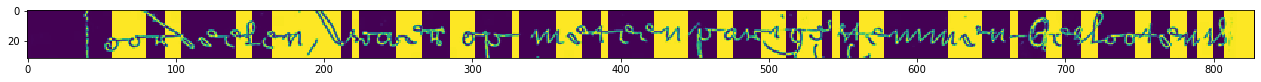

In [ ]:
plt.figure(figsize=(22,22))
plt.imshow(digit_img.squeeze().transpose(0,1))

In [ ]:
labeling_info, labels_probs = image_scorer.test_model_labeling(pixelcnn_rec, 1, replaced_digit_prob_only=False)

Digit with index 1: 3
After replecing 3 with 0 sum of image pixels log probabilities is -10473.4453125
After replecing 3 with 1 sum of image pixels log probabilities is -10476.140625
After replecing 3 with 2 sum of image pixels log probabilities is -10477.1728515625
After replecing 3 with 3 sum of image pixels log probabilities is -10463.259765625
After replecing 3 with 4 sum of image pixels log probabilities is -10483.5546875
After replecing 3 with 5 sum of image pixels log probabilities is -10478.2568359375
After replecing 3 with 6 sum of image pixels log probabilities is -10479.373046875
After replecing 3 with 7 sum of image pixels log probabilities is -10466.9052734375
After replecing 3 with 8 sum of image pixels log probabilities is -10473.98046875
After replecing 3 with 9 sum of image pixels log probabilities is -10480.3759765625
After replecing 3 with 10 sum of image pixels log probabilities is -10477.447265625
After replecing 3 with 11 sum of image pixels log probabilities is -

In [ ]:
labels_probs

(tensor([3]),
 tensor([0.9486]),
 tensor([3.5772e-05, 2.4153e-06, 8.6038e-07, 9.4856e-01, 1.4558e-09, 2.9102e-07,
         9.5314e-08, 2.4765e-02, 2.0947e-05, 3.4961e-08, 6.5390e-07, 1.5728e-08,
         3.3213e-05, 1.0659e-04, 3.5887e-03, 3.8970e-07, 3.9314e-07, 1.8397e-11,
         2.3047e-06, 1.5788e-02, 4.5332e-08, 5.6446e-11, 5.6979e-07, 2.0330e-09,
         1.2930e-05, 1.5800e-10, 1.0875e-07, 7.7705e-09, 1.0709e-05, 5.1010e-09,
         2.2245e-08, 7.3869e-08, 1.2637e-08, 1.7228e-06, 4.2480e-05, 2.1396e-07,
         1.1623e-06, 2.7308e-08, 6.2673e-10, 1.8662e-07, 1.0745e-09, 5.9026e-06,
         1.1156e-06, 7.8433e-12, 2.4956e-03, 1.3148e-11, 2.6380e-04, 1.1750e-05,
         2.9179e-09, 6.4203e-12, 3.6774e-03, 8.0698e-11, 2.2653e-04, 2.1615e-04,
         4.6589e-08, 6.2101e-06, 1.3814e-07, 4.1658e-05, 5.0861e-09, 4.2407e-10,
         7.5066e-05, 8.5986e-11, 1.2604e-06, 2.2861e-08, 1.1189e-19, 2.1264e-09,
         4.6425e-12, 9.0350e-13]))

In [ ]:
pixelcnn_alignment_tester = ModelAlignmentCoincidentTester(pixelcnn_rec, scribblelens_test_loader)

In [ ]:
pixelcnn_alignment_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 177 (0.59%)          	Miscalssified: 123 (0.41%)
Average probability assigned to the true symbol was: 0.55
Average probability assigned to the true symbol, when classified correctly was: 0.86
Average probability of most likely symbol while misclassifying was: 0.53
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 8
  '*': 6
  ',': 1
  Z: 1
  a: 5
  b: 2
  c: 6
  d: 11
  e: 44
  f: 1
  g: 5
  h: 5
  i: 6
  j: 2
  k: 4
  l: 8
  m: 2
  n: 12
  o: 7
  p: 3
  r: 8
  s: 7
  t: 13
  u: 4
  v: 2
  w: 1
  y: 1
  z: 1
  "\xB4": 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 34
  '*': 7
  ',': 2
  W: 2
  a: 7
  b: 2
  c: 2
  d: 6
  e: 7
  g: 1
  h: 1
  i: 7
  j: 1
  l: 3
  m: 3
  n: 15
  o: 4
  p: 1
  r: 3
  s: 1
  t: 5
  u: 1
  v: 2
  x: 1
  y: 1
  z: 3
  "\xB4": 1

When classifying symbol o it's avg probability was: 0.6704085442152891
When classifying symbol r it's avg probability

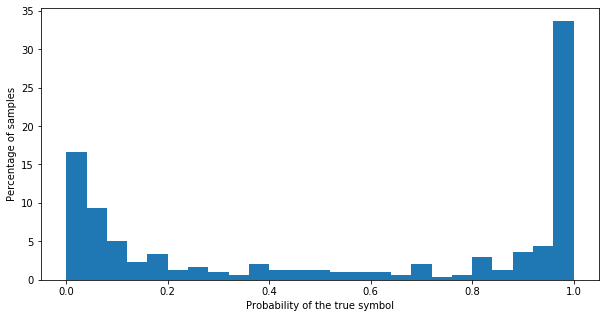

Histogram of highest assgined probability while processing each of symbols:


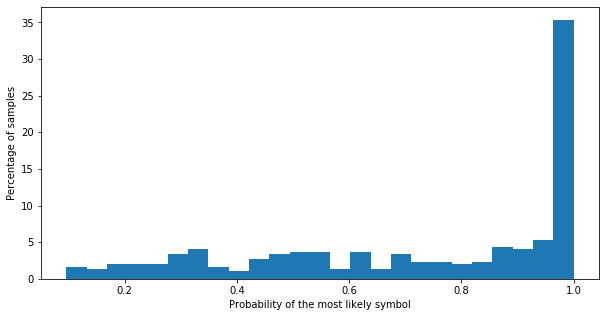

In [ ]:
pixelcnn_alignment_tester.summary()

Symbol d at position 3 was misclassified as 9.
Probability of the true symbol: 0.10374262183904648. Probability of 9: 0.46087369322776794


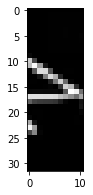

Symbol   at position 8 was misclassified as J.
Probability of the true symbol: 0.00031065198709256947. Probability of J: 0.42563164234161377


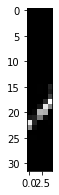

Symbol W at position 9 was misclassified as v.
Probability of the true symbol: 0.00023256892745848745. Probability of v: 0.826510488986969


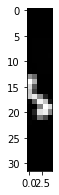

Symbol   at position 15 was misclassified as f.
Probability of the true symbol: 0.057711463421583176. Probability of f: 0.1322319209575653


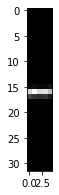

Symbol t at position 18 was misclassified as n.
Probability of the true symbol: 0.017135921865701675. Probability of n: 0.9301236867904663


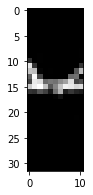

Symbol   at position 19 was misclassified as o.
Probability of the true symbol: 0.044012006372213364. Probability of o: 0.3699503242969513


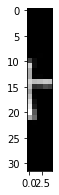

Symbol g at position 26 was misclassified as o.
Probability of the true symbol: 0.26361799240112305. Probability of o: 0.4067077338695526


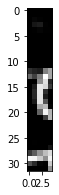

Symbol e at position 27 was misclassified as ´.
Probability of the true symbol: 0.015042421407997608. Probability of ´: 0.7745487093925476


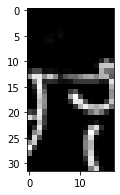

Symbol   at position 28 was misclassified as 3.
Probability of the true symbol: 0.04200531914830208. Probability of 3: 0.27098244428634644


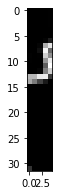

Symbol s at position 29 was misclassified as I.
Probability of the true symbol: 0.0012637923937290907. Probability of I: 0.31905612349510193


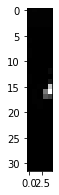

In [ ]:
pixelcnn_alignment_tester.show_badly_classified(10)

In [ ]:
pixelcnn_alignment_tester.ignore(" ")

Classified samples: 263          	Classified correctly: 171 (0.65%)          	Miscalssified: 92 (0.35%)
Average probability assigned to the true symbol was: 0.6151570708803823
Average probability assigned to the true symbol, when classified correctly was: 0.8845630087699109
Average probability of most likely symbol while misclassifying was: 0.6319751143455505
Symbols classified correctly: !!python/object/apply:collections.Counter
- '*': 8
  ',': 1
  W: 1
  Z: 1
  a: 8
  b: 2
  c: 5
  d: 10
  e: 42
  f: 1
  g: 4
  h: 3
  i: 6
  j: 2
  k: 2
  l: 9
  m: 3
  n: 12
  o: 9
  p: 3
  r: 8
  s: 6
  t: 14
  u: 3
  v: 3
  w: 1
  y: 2
  z: 1
  "\xB4": 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 5
  '*': 5
  ',': 2
  W: 1
  a: 4
  b: 2
  c: 3
  d: 7
  e: 9
  g: 2
  h: 3
  i: 7
  j: 1
  k: 2
  l: 2
  m: 2
  n: 15
  o: 2
  p: 1
  r: 3
  s: 2
  t: 4
  u: 2
  v: 1
  x: 1
  z: 3
  "\xB4": 1

When classifying symbol * it's avg probability was: 0.5545261598599609
When cla

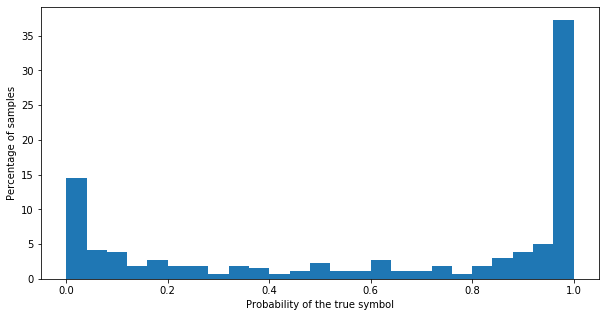

Histogram of highest assgined probability while processing each of symbols:


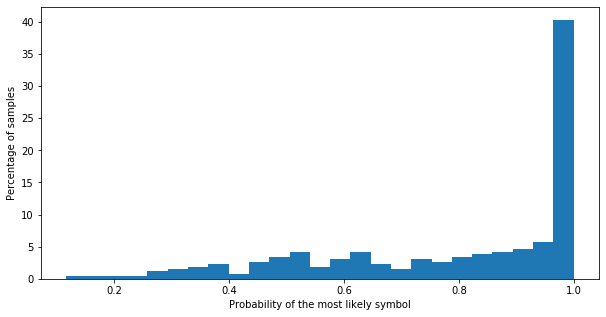

In [ ]:
pixelcnn_alignment_tester.summary()

In [ ]:
cond = torch.tensor([0]*20 + [12]*12 + [24]*10 + [1]*15 + [3]*10 + [6]*10 + [1]*15 + [23]*13 + [0]*20).int()

In [ ]:
s = pixelcnn_rec.sample(cond)

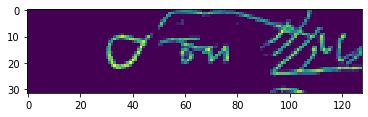

In [ ]:
plt.imshow(s.squeeze().data.cpu().transpose(0,1))

### No alignmnet

In [ ]:
pixelcnn_rec_no_align = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   ignore_alignment=True
                                   )

In [ ]:
pixelcnn_rec_no_align_trainer = ReconstructorTrainer(pixelcnn_rec_no_align, scribblelens_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_PixelCNN_no_align",
               serialize_epochs=30,
               serialize_sample=None)

In [ ]:
pixelcnn_rec_no_align_optim = optim.Adam(pixelcnn_rec_no_align.parameters(), lr=1e-3)
optim_scheduler = optim.lr_scheduler.StepLR(pixelcnn_rec_no_align_optim, step_size=20, gamma=0.1)

In [ ]:
pixelcnn_rec_no_align_losses = pixelcnn_rec_no_align_trainer.train(pixelcnn_rec_no_align_optim, 100, optim_scheduler)

Train Epoch: 1 [0/963 (0%)]	Loss: 1130765.625000
Applying LR scheduler...
Train Epoch: 2 [0/963 (0%)]	Loss: 295556.062500
Applying LR scheduler...
Train Epoch: 3 [0/963 (0%)]	Loss: 248331.906250
Applying LR scheduler...
Train Epoch: 4 [0/963 (0%)]	Loss: 210516.062500
Applying LR scheduler...
Train Epoch: 5 [0/963 (0%)]	Loss: 191143.281250
Applying LR scheduler...
Train Epoch: 6 [0/963 (0%)]	Loss: 183970.468750
Applying LR scheduler...
Train Epoch: 7 [0/963 (0%)]	Loss: 178843.656250
Applying LR scheduler...
Train Epoch: 8 [0/963 (0%)]	Loss: 177175.343750
Applying LR scheduler...
Train Epoch: 9 [0/963 (0%)]	Loss: 173696.750000
Applying LR scheduler...
Train Epoch: 10 [0/963 (0%)]	Loss: 171770.656250
Applying LR scheduler...
Train Epoch: 11 [0/963 (0%)]	Loss: 172012.031250
Applying LR scheduler...
Train Epoch: 12 [0/963 (0%)]	Loss: 167937.984375
Applying LR scheduler...
Train Epoch: 13 [0/963 (0%)]	Loss: 165087.656250
Applying LR scheduler...
Train Epoch: 14 [0/963 (0%)]	Loss: 163781.5000

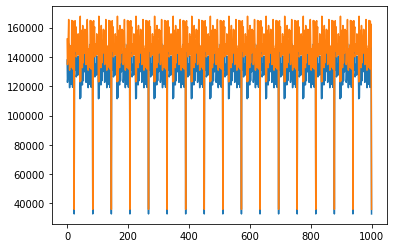

In [ ]:
plt.plot(np.arange(1000), pixelcnn_rec_losses[-1000:])
plt.plot(np.arange(1000), pixelcnn_rec_no_align_losses[-1000:])

### Lookahead PixelCNN

In [ ]:
pixelcnn_lookahead_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.LookaheadColumnGatedPixelCNN',
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_PixelCNN_lookahead_2019-12-15_09:35:40.pkl'
checkpoint = torch.load(model_serialize_path)
pixelcnn_lookahead_rec.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
pixelcnn_lookahead_trainer = ReconstructorTrainer(pixelcnn_lookahead_rec, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_PixelCNN_lookahead",
               serialize_epochs=50,
               serialize_sample=None)

In [ ]:
pixelcnn_lookahead_optim = optim.Adam(pixelcnn_lookahead_rec.parameters(), lr=1e-3)

In [ ]:
ml_monitor.set_training("Scribblelens_PixelCNN_lookahead_tune")

In [ ]:
pixelcnn_lookahead_losses = pixelcnn_lookahead_trainer.train(pixelcnn_lookahead_optim, 20)

Train Epoch: 1 [0/3852 (0%)]	Loss: 53267.007812
Train Epoch: 1 [3200/3852 (83%)]	Loss: 66864.570312
Train Epoch: 2 [0/3852 (0%)]	Loss: 40128.484375
Train Epoch: 2 [3200/3852 (83%)]	Loss: 56275.968750
Train Epoch: 3 [0/3852 (0%)]	Loss: 65677.765625
Train Epoch: 3 [3200/3852 (83%)]	Loss: 56170.546875
Train Epoch: 4 [0/3852 (0%)]	Loss: 43548.613281
Train Epoch: 4 [3200/3852 (83%)]	Loss: 45220.179688
Train Epoch: 5 [0/3852 (0%)]	Loss: 42015.742188
Train Epoch: 5 [3200/3852 (83%)]	Loss: 43670.679688
Train Epoch: 6 [0/3852 (0%)]	Loss: 69631.148438
Train Epoch: 6 [3200/3852 (83%)]	Loss: 43566.968750
Train Epoch: 7 [0/3852 (0%)]	Loss: 43644.476562
Train Epoch: 7 [3200/3852 (83%)]	Loss: 58862.511719
Train Epoch: 8 [0/3852 (0%)]	Loss: 67593.015625
Train Epoch: 8 [3200/3852 (83%)]	Loss: 56431.105469
Train Epoch: 9 [0/3852 (0%)]	Loss: 68092.718750
Train Epoch: 9 [3200/3852 (83%)]	Loss: 50546.644531
Train Epoch: 10 [0/3852 (0%)]	Loss: 56919.015625
Train Epoch: 10 [3200/3852 (83%)]	Loss: 44771.58593

In [ ]:
pixelcnn_lookahead_alignment_tester = ModelAlignmentCoincidentTester(pixelcnn_lookahead_rec, scribblelens_test_loader)

In [ ]:
pixelcnn_lookahead_alignment_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 80 (0.26666666666666666%)          	Miscalssified: 220 (0.7333333333333333%)
Average probability assigned to the true symbol was: 0.2421026223532313
Average probability assigned to the true symbol, when classified correctly was: 0.8312448274344206
Average probability of most likely symbol while misclassifying was: 0.7196488976478577
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 11
  '*': 6
  a: 2
  c: 4
  d: 4
  e: 22
  h: 1
  i: 2
  j: 1
  l: 3
  n: 5
  o: 2
  p: 1
  r: 4
  s: 3
  t: 8
  v: 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 31
  '*': 7
  ',': 3
  W: 2
  Z: 1
  a: 10
  b: 4
  c: 4
  d: 13
  e: 29
  f: 1
  g: 6
  h: 5
  i: 11
  j: 2
  k: 4
  l: 8
  m: 5
  n: 22
  o: 9
  p: 3
  r: 7
  s: 5
  t: 10
  u: 5
  v: 3
  w: 1
  x: 1
  y: 2
  z: 4
  "\xB4": 2

When classifying symbol r it's avg probability was: 0.34407875483686273
When classifying symbol l it's avg 

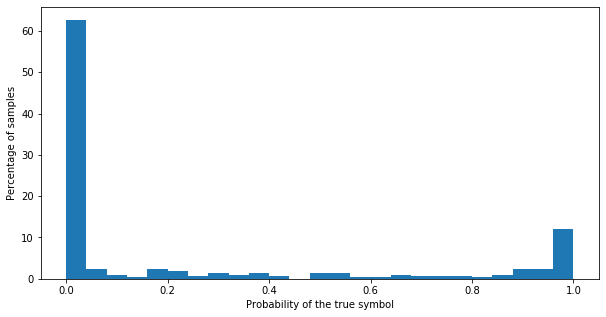

Histogram of highest assgined probability while processing each of symbols:


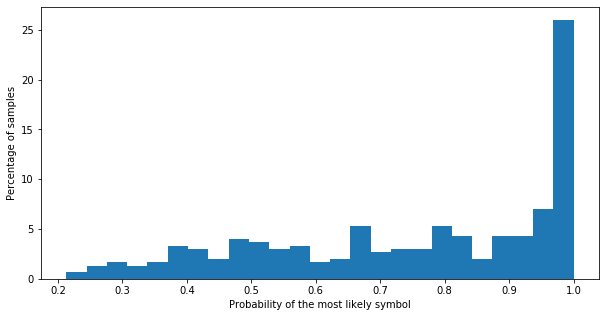

In [ ]:
pixelcnn_lookahead_alignment_tester.summary()

## Wavenet

In [ ]:
wavenet_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                       'wave_net': {
                                          'class_name': 'distsup.modules.wavenet.WaveNet',
                                       },
                                       'num_layers': 10,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_2019-12-09_16:22:44.pkl'
checkpoint = torch.load(model_serialize_path)
wavenet_rec.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
wavenet_rec_trainer = ReconstructorTrainer(wavenet_rec, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_WaveNet",
               serialize_epochs=100,
               serialize_sample=None)

In [ ]:
wavenet_optim = optim.Adam(wavenet_rec.parameters(), lr=1e-3)
optim_scheduler = optim.lr_scheduler.StepLR(wavenet_optim, step_size=70, gamma=0.1)

In [ ]:
ml_monitor.set_training("Scribblelens_WaveNet")

In [ ]:
wavenet_losses = wavenet_rec_trainer.train(wavenet_optim, 125, optim_scheduler)

Train Epoch: 1 [0/3852 (0%)]	Loss: 46259.968750
Train Epoch: 1 [3200/3852 (83%)]	Loss: 45512.792969
Applying LR scheduler...
Train Epoch: 2 [0/3852 (0%)]	Loss: 46265.226562
Train Epoch: 2 [3200/3852 (83%)]	Loss: 43494.273438
Applying LR scheduler...
Train Epoch: 3 [0/3852 (0%)]	Loss: 45940.027344
Train Epoch: 3 [3200/3852 (83%)]	Loss: 47980.625000
Applying LR scheduler...
Train Epoch: 4 [0/3852 (0%)]	Loss: 45534.378906
Train Epoch: 4 [3200/3852 (83%)]	Loss: 41612.261719
Applying LR scheduler...
Train Epoch: 5 [0/3852 (0%)]	Loss: 45101.984375
Train Epoch: 5 [3200/3852 (83%)]	Loss: 45863.726562
Applying LR scheduler...
Train Epoch: 6 [0/3852 (0%)]	Loss: 43482.859375
Train Epoch: 6 [3200/3852 (83%)]	Loss: 45647.968750
Applying LR scheduler...
Train Epoch: 7 [0/3852 (0%)]	Loss: 41779.085938
Train Epoch: 7 [3200/3852 (83%)]	Loss: 44442.828125
Applying LR scheduler...
Train Epoch: 8 [0/3852 (0%)]	Loss: 44563.171875
Train Epoch: 8 [3200/3852 (83%)]	Loss: 44452.632812
Applying LR scheduler...


In [ ]:
wavenet_rec_trainer.serialize(97, wavenet_optim)

Model serialized as /content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_2019-12-09_16:22:44.pkl


In [ ]:
wavenet_alignment_tester = ModelAlignmentCoincidentTester(wavenet_rec, scribblelens_test_loader)

In [ ]:
wavenet_alignment_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 117 (0.39%)          	Miscalssified: 183 (0.61%)
Average probability assigned to the true symbol was: 0.3922578550455152
Average probability assigned to the true symbol, when classified correctly was: 0.9403569665220048
Average probability of most likely symbol while misclassifying was: 0.8141573071479797
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 6
  '*': 5
  a: 5
  b: 1
  d: 5
  e: 33
  f: 1
  g: 2
  h: 3
  i: 3
  j: 1
  k: 3
  l: 7
  m: 1
  n: 7
  o: 4
  p: 2
  r: 7
  s: 4
  t: 8
  u: 3
  v: 3
  w: 1
  y: 1
  z: 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 36
  '*': 8
  ',': 3
  W: 2
  Z: 1
  a: 7
  b: 3
  c: 8
  d: 12
  e: 18
  g: 4
  h: 3
  i: 10
  j: 2
  k: 1
  l: 4
  m: 4
  n: 20
  o: 7
  p: 2
  r: 4
  s: 4
  t: 10
  u: 2
  v: 1
  x: 1
  y: 1
  z: 3
  "\xB4": 2

When classifying symbol * it's avg probability was: 0.3757496644765809
When classifying symbol 

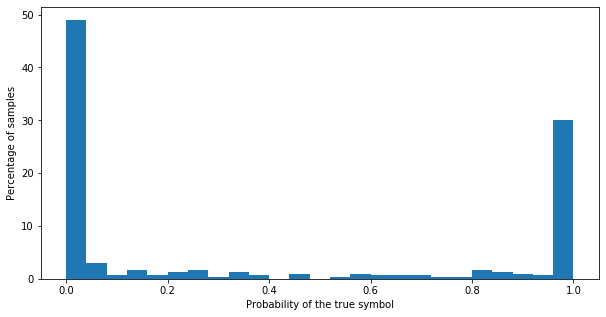

Histogram of highest assgined probability while processing each of symbols:


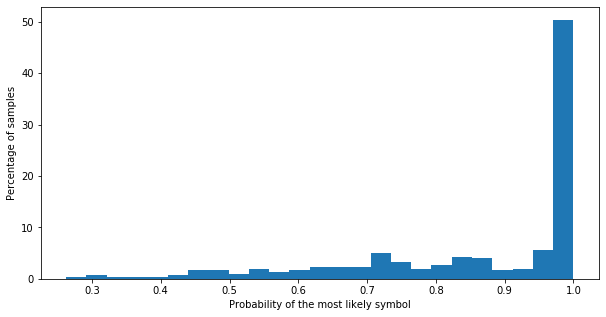

In [ ]:
wavenet_alignment_tester.summary()

Symbol o at position 1 was misclassified as *.
Probability of the true symbol: 0.20926624536514282. Probability of *: 0.7219014167785645


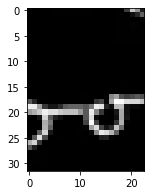

Symbol r at position 2 was misclassified as v.
Probability of the true symbol: 0.3494393825531006. Probability of v: 0.6502935290336609


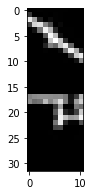

Symbol d at position 3 was misclassified as v.
Probability of the true symbol: 0.0030149435624480247. Probability of v: 0.7234633564949036


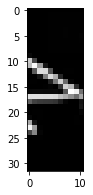

Symbol e at position 4 was misclassified as d.
Probability of the true symbol: 0.00033633370185270905. Probability of d: 0.9996637105941772


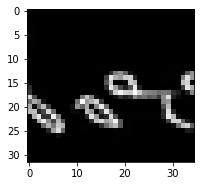

Symbol n at position 7 was misclassified as s.
Probability of the true symbol: 1.607269553005608e-07. Probability of s: 0.9999958276748657


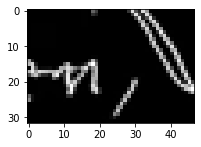

Symbol   at position 8 was misclassified as F.
Probability of the true symbol: 5.567937932937639e-06. Probability of F: 0.6463743448257446


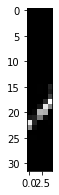

Symbol W at position 9 was misclassified as r.
Probability of the true symbol: 0.005784884095191956. Probability of r: 0.9596574902534485


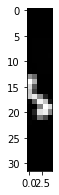

Symbol a at position 10 was misclassified as i.
Probability of the true symbol: 0.014308617450296879. Probability of i: 0.9856327772140503


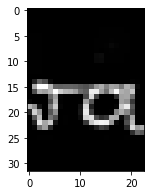

Symbol r at position 12 was misclassified as s.
Probability of the true symbol: 0.47804126143455505. Probability of s: 0.5219582915306091


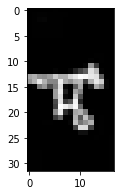

Symbol o at position 13 was misclassified as  .
Probability of the true symbol: 0.0004382863116916269. Probability of  : 0.818393886089325


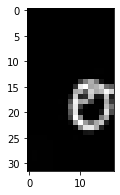

In [ ]:
wavenet_alignment_tester.show_badly_classified(10)

In [ ]:
wavenet_alignment_tester.ignore(" ")

Classified samples: 260          	Classified correctly: 111 (0.43%)          	Miscalssified: 149 (0.57%)
Average probability assigned to the true symbol was: 0.4321632021340829
Average probability assigned to the true symbol, when classified correctly was: 0.9484052255346969
Average probability of most likely symbol while misclassifying was: 0.8394492268562317
Symbols classified correctly: !!python/object/apply:collections.Counter
- '*': 5
  a: 5
  b: 1
  d: 5
  e: 33
  f: 1
  g: 2
  h: 3
  i: 3
  j: 1
  k: 3
  l: 7
  m: 1
  n: 7
  o: 4
  p: 2
  r: 7
  s: 4
  t: 8
  u: 3
  v: 3
  w: 1
  y: 1
  z: 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 2
  '*': 8
  ',': 3
  W: 2
  Z: 1
  a: 7
  b: 3
  c: 8
  d: 12
  e: 18
  g: 4
  h: 3
  i: 10
  j: 2
  k: 1
  l: 4
  m: 4
  n: 20
  o: 7
  p: 2
  r: 4
  s: 4
  t: 10
  u: 2
  v: 1
  x: 1
  y: 1
  z: 3
  "\xB4": 2

When classifying symbol * it's avg probability was: 0.3757496644765809
When classifying symbol l it's avg

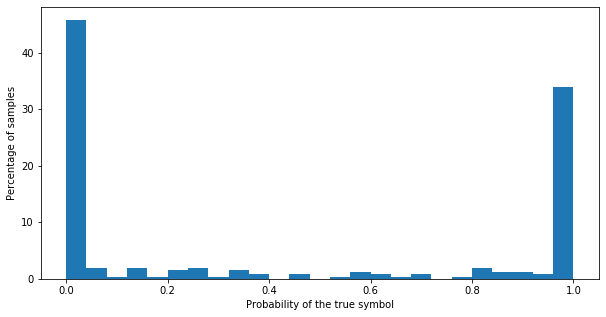

Histogram of highest assgined probability while processing each of symbols:


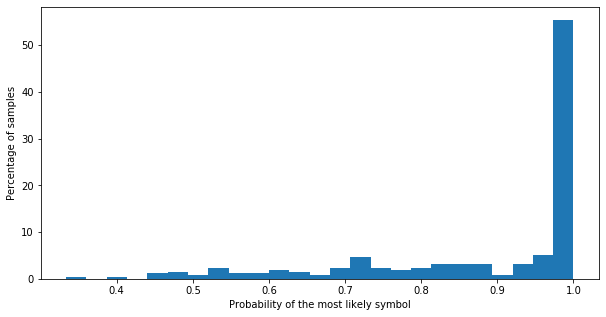

In [ ]:
wavenet_alignment_tester.summary()

In [ ]:
cond = torch.tensor([0]*20 + [12]*12 + [24]*10 + [1]*15 + [3]*10 + [6]*10 + [1]*15 + [23]*13 + [0]*20).int()

In [ ]:
s_p = pixelcnn_rec.sample(cond)
s_w = wavenet_rec.sample(cond)

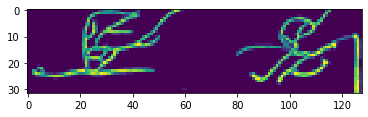

In [ ]:
plt.imshow(s_p.squeeze().data.cpu().transpose(0,1))

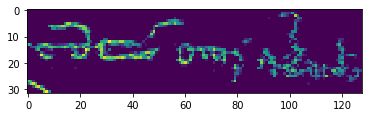

In [ ]:
plt.imshow(s_w.squeeze().data.cpu().transpose(0,1))

### Wavenet, reduction length modified

In [ ]:
wavenet_rec_rlen = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   len_reduction=8,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                       'wave_net': {
                                          'class_name': 'distsup.modules.wavenet.WaveNet',
                                       },
                                       'num_layers': 10,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_rlen_2019-12-12_18:04:24.pkl'
checkpoint = torch.load(model_serialize_path)
wavenet_rec_rlen.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
wavenet_rec_rlen_trainer = ReconstructorTrainer(wavenet_rec_rlen, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_WaveNet_rlen",
               serialize_epochs=100,
               serialize_sample=None)

In [ ]:
wavenet_rlen_optim = optim.Adam(wavenet_rec_rlen.parameters(), lr=1e-3)
optim_scheduler = optim.lr_scheduler.StepLR(wavenet_rlen_optim, step_size=70, gamma=0.1)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_WaveNet_rlen")

In [ ]:
wavenet_rlen_losses = wavenet_rec_rlen_trainer.train(wavenet_rlen_optim, 100, optim_scheduler)

Train Epoch: 1 [0/3852 (0%)]	Loss: 43443.328125
Train Epoch: 1 [3200/3852 (83%)]	Loss: 49729.664062
Applying LR scheduler...
Train Epoch: 2 [0/3852 (0%)]	Loss: 46901.390625
Train Epoch: 2 [3200/3852 (83%)]	Loss: 46162.324219
Applying LR scheduler...
Train Epoch: 3 [0/3852 (0%)]	Loss: 48338.664062
Train Epoch: 3 [3200/3852 (83%)]	Loss: 45468.546875
Applying LR scheduler...
Train Epoch: 4 [0/3852 (0%)]	Loss: 44290.289062
Train Epoch: 4 [3200/3852 (83%)]	Loss: 44473.671875
Applying LR scheduler...
Train Epoch: 5 [0/3852 (0%)]	Loss: 46449.164062
Train Epoch: 5 [3200/3852 (83%)]	Loss: 48392.171875
Applying LR scheduler...
Train Epoch: 6 [0/3852 (0%)]	Loss: 43236.445312
Train Epoch: 6 [3200/3852 (83%)]	Loss: 47035.628906
Applying LR scheduler...
Train Epoch: 7 [0/3852 (0%)]	Loss: 46405.199219
Train Epoch: 7 [3200/3852 (83%)]	Loss: 48635.828125
Applying LR scheduler...
Train Epoch: 8 [0/3852 (0%)]	Loss: 46613.140625
Train Epoch: 8 [3200/3852 (83%)]	Loss: 48429.992188
Applying LR scheduler...


In [ ]:
wavenet_rlen_alignment_tester = ModelAlignmentCoincidentTester(wavenet_rec_rlen, scribblelens_test_loader)

In [ ]:
wavenet_rlen_alignment_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 94 (0.31%)          	Miscalssified: 206 (0.69%)
Average probability assigned to the true symbol was: 0.3156524988146358
Average probability assigned to the true symbol, when classified correctly was: 0.9388206125573909
Average probability of most likely symbol while misclassifying was: 0.8372316956520081
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 3
  '*': 4
  W: 1
  a: 3
  b: 1
  c: 1
  d: 5
  e: 25
  g: 2
  h: 2
  i: 3
  j: 1
  k: 2
  l: 5
  m: 2
  n: 7
  o: 4
  p: 2
  r: 6
  s: 1
  t: 7
  u: 3
  v: 2
  w: 1
  z: 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 39
  '*': 9
  ',': 3
  W: 1
  Z: 1
  a: 9
  b: 3
  c: 7
  d: 12
  e: 26
  f: 1
  g: 4
  h: 4
  i: 10
  j: 2
  k: 2
  l: 6
  m: 3
  n: 20
  o: 7
  p: 2
  r: 5
  s: 7
  t: 11
  u: 2
  v: 2
  x: 1
  y: 2
  z: 3
  "\xB4": 2

When classifying symbol o it's avg probability was: 0.3464660731907452
When classifying s

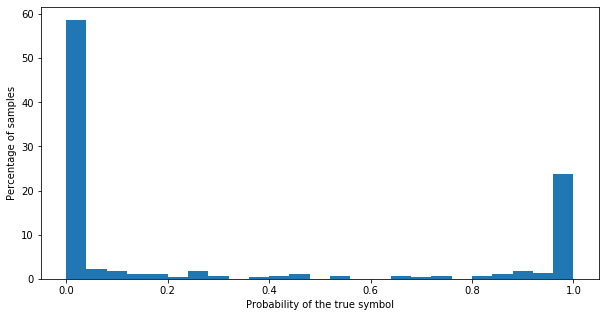

Histogram of highest assgined probability while processing each of symbols:


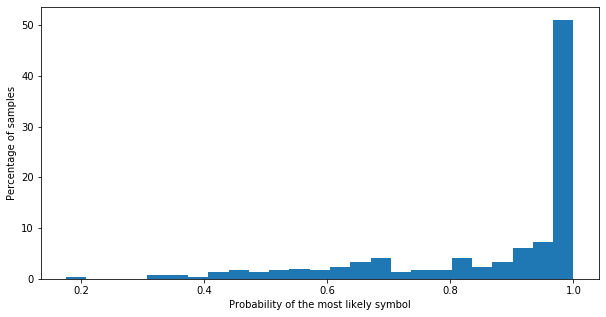

In [ ]:
wavenet_rlen_alignment_tester.summary()

In [ ]:
wavenet_rlen_alignment_tester.ignore(" ")

Classified samples: 259          	Classified correctly: 91 (0.35%)          	Miscalssified: 168 (0.65%)
Average probability assigned to the true symbol was: 0.35094208876271615
Average probability assigned to the true symbol, when classified correctly was: 0.9463684513018682
Average probability of most likely symbol while misclassifying was: 0.8534809350967407
Symbols classified correctly: !!python/object/apply:collections.Counter
- '*': 4
  W: 1
  a: 3
  b: 1
  c: 1
  d: 5
  e: 25
  g: 2
  h: 2
  i: 3
  j: 1
  k: 2
  l: 5
  m: 2
  n: 7
  o: 4
  p: 2
  r: 6
  s: 1
  t: 7
  u: 3
  v: 2
  w: 1
  z: 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 1
  '*': 9
  ',': 3
  W: 1
  Z: 1
  a: 9
  b: 3
  c: 7
  d: 12
  e: 26
  f: 1
  g: 4
  h: 4
  i: 10
  j: 2
  k: 2
  l: 6
  m: 3
  n: 20
  o: 7
  p: 2
  r: 5
  s: 7
  t: 11
  u: 2
  v: 2
  x: 1
  y: 2
  z: 3
  "\xB4": 2

When classifying symbol o it's avg probability was: 0.3464660731907452
When classifying symbol e i

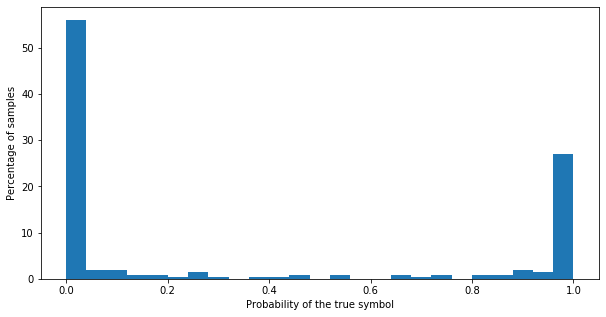

Histogram of highest assgined probability while processing each of symbols:


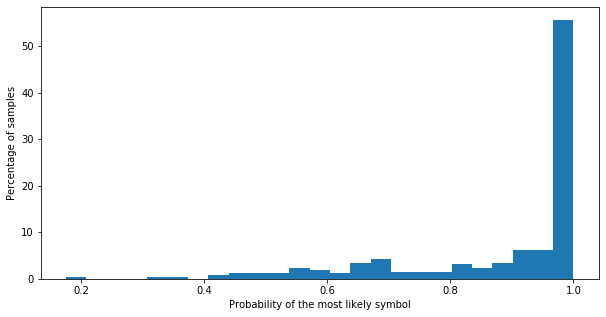

In [ ]:
wavenet_rlen_alignment_tester.summary()

### Reduction length = 1

In [ ]:
wavenet_rec_no_red = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   len_reduction=1,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                       'wave_net': {
                                          'class_name': 'distsup.modules.wavenet.WaveNet',
                                       },
                                       'num_layers': 10,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   )

In [ ]:
wavenet_rec_no_red.load_state_dict(wavenet_rec.state_dict())

<All keys matched successfully>

In [ ]:
wavenet_no_red_trainer = ReconstructorTrainer(wavenet_rec_no_red, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_WaveNet_no_red",
               serialize_epochs=100,
               serialize_sample=None)

In [ ]:
wavenet_no_red_optim = optim.Adam(wavenet_rec_no_red.parameters(), lr=1e-3)
optim_scheduler = optim.lr_scheduler.StepLR(wavenet_no_red_optim, step_size=70, gamma=0.1)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_WaveNet_no_red")

In [ ]:
wavenet_no_red_losses = wavenet_no_red_trainer.train(wavenet_no_red_optim, 50, optim_scheduler)

In [ ]:
wavenet_no_red_alignment_tester = ModelAlignmentCoincidentTester(wavenet_rec_no_red, scribblelens_test_loader)

In [ ]:
wavenet_no_red_alignment_tester.test_alignment_image_relation(200)

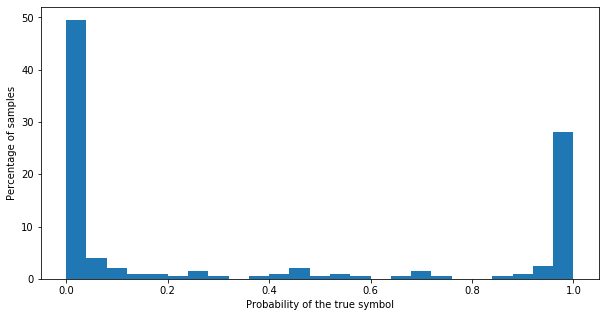

In [ ]:
wavenet_no_red_alignment_tester.alignment_pbb_chart()

### Noisy alignment

In [ ]:
wavenet_rec_noisy = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   len_reduction=4,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                       'wave_net': {
                                          'class_name': 'distsup.modules.wavenet.WaveNet',
                                       },
                                       'num_layers': 10,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   alignment_noise_pbb=0.1
                                   )

In [ ]:
wavenet_rec_noisy.load_state_dict(wavenet_rec.state_dict())

<All keys matched successfully>

In [ ]:
wavenet_rec_noisy_trainer = ReconstructorTrainer(wavenet_rec_noisy, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_WaveNet_noisy",
               serialize_epochs=100,
               serialize_sample=None)

In [ ]:
wavenet_noisy_optim = optim.Adam(wavenet_rec_noisy.parameters(), lr=1e-3)
optim_scheduler = optim.lr_scheduler.StepLR(wavenet_noisy_optim, step_size=70, gamma=0.1)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_WaveNet_noisy")

In [ ]:
wavenet_noisy_losses = wavenet_rec_noisy_trainer.train(wavenet_noisy_optim, 50, optim_scheduler)

Train Epoch: 1 [0/3852 (0%)]	Loss: 43058.066406
Train Epoch: 1 [3200/3852 (83%)]	Loss: 43880.273438
Applying LR scheduler...
Train Epoch: 2 [0/3852 (0%)]	Loss: 45197.445312
Train Epoch: 2 [3200/3852 (83%)]	Loss: 44437.125000
Applying LR scheduler...
Train Epoch: 3 [0/3852 (0%)]	Loss: 49342.265625
Train Epoch: 3 [3200/3852 (83%)]	Loss: 44638.703125
Applying LR scheduler...
Train Epoch: 4 [0/3852 (0%)]	Loss: 42977.460938
Train Epoch: 4 [3200/3852 (83%)]	Loss: 47688.570312
Applying LR scheduler...
Train Epoch: 5 [0/3852 (0%)]	Loss: 48915.617188
Train Epoch: 5 [3200/3852 (83%)]	Loss: 48222.570312
Applying LR scheduler...
Train Epoch: 6 [0/3852 (0%)]	Loss: 46930.679688
Train Epoch: 6 [3200/3852 (83%)]	Loss: 44761.609375
Applying LR scheduler...
Train Epoch: 7 [0/3852 (0%)]	Loss: 45038.730469
Train Epoch: 7 [3200/3852 (83%)]	Loss: 49171.667969
Applying LR scheduler...
Train Epoch: 8 [0/3852 (0%)]	Loss: 40988.011719
Train Epoch: 8 [3200/3852 (83%)]	Loss: 48338.718750
Applying LR scheduler...


In [ ]:
reduced_align_noisy1 = wavenet_rec_noisy.transform_alignment(sample_test_cond.long()[None,:].to(device)).squeeze()

In [ ]:
reduced_align_noisy2 = wavenet_rec_noisy.transform_alignment(sample_test_cond.long()[None,:].to(device)).squeeze()

In [ ]:
reduced_align_noisy3 = wavenet_rec_noisy.transform_alignment(sample_test_cond.long()[None,:].to(device)).squeeze()

In [ ]:
torch.sum(reduced_align_noisy1 != reduced_align_noisy2)

tensor(49, device='cuda:0')

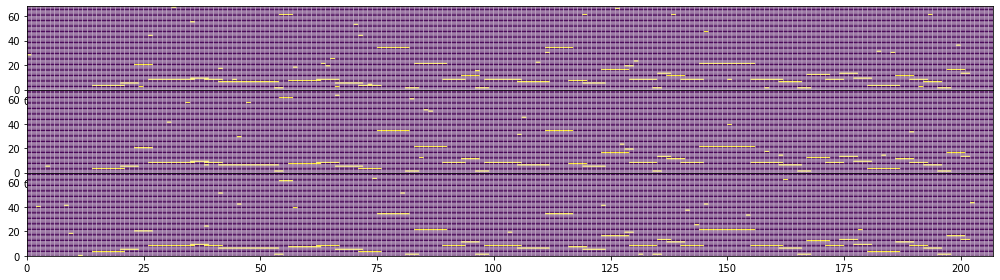

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(14,4))
axs[0].pcolor(np.array(reduced_align_noisy1.transpose(0,1).data.cpu()),edgecolors='w')
axs[1].pcolor(np.array(reduced_align_noisy2.transpose(0,1).data.cpu()),edgecolors='w')
axs[2].pcolor(np.array(reduced_align_noisy3.transpose(0,1).data.cpu()),edgecolors='w')
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
wavenet_noisy_alignment_tester = ModelAlignmentCoincidentTester(wavenet_rec_noisy, scribblelens_test_loader)

In [ ]:
wavenet_noisy_alignment_tester.test_alignment_image_relation(200)

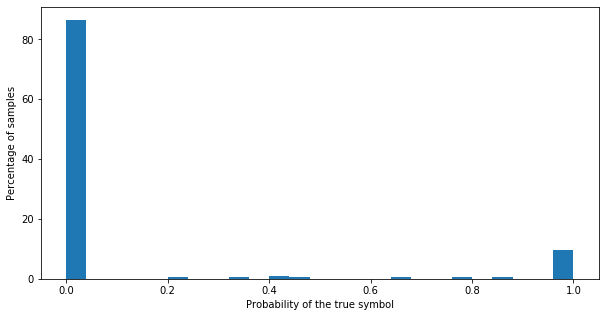

In [ ]:
wavenet_noisy_alignment_tester.alignment_pbb_chart()

In [ ]:
len(wavenet_noisy_alignment_tester.correctly_classified) / len(wavenet_noisy_alignment_tester.correctly_classified + wavenet_noisy_alignment_tester.badly_classified)

0.115

### smaller Wavenet

In [ ]:
wavenet_s_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                       'wave_net': {
                                          'class_name': 'distsup.modules.wavenet.WaveNet',
                                       },
                                       'num_layers': 5,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   )

In [ ]:
wavenet_s_trainer = ReconstructorTrainer(wavenet_s_rec, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_WaveNet_S",
               serialize_epochs=100,
               serialize_sample=None)

In [ ]:
wavenet_s_optim = optim.Adam(wavenet_s_rec.parameters(), lr=1e-3)
optim_scheduler = optim.lr_scheduler.StepLR(wavenet_s_optim, step_size=70, gamma=0.1)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_WaveNet_small")

In [ ]:
wavenet_s_losses = wavenet_s_trainer.train(wavenet_s_optim, 55, optim_scheduler)

Train Epoch: 1 [0/3852 (0%)]	Loss: 273128.875000
Train Epoch: 1 [3200/3852 (83%)]	Loss: 77774.445312
Applying LR scheduler...
Train Epoch: 2 [0/3852 (0%)]	Loss: 79798.242188
Train Epoch: 2 [3200/3852 (83%)]	Loss: 73352.531250
Applying LR scheduler...
Train Epoch: 3 [0/3852 (0%)]	Loss: 69927.132812
Train Epoch: 3 [3200/3852 (83%)]	Loss: 58729.804688
Applying LR scheduler...
Train Epoch: 4 [0/3852 (0%)]	Loss: 70325.007812
Train Epoch: 4 [3200/3852 (83%)]	Loss: 69236.453125
Applying LR scheduler...
Train Epoch: 5 [0/3852 (0%)]	Loss: 66350.625000
Train Epoch: 5 [3200/3852 (83%)]	Loss: 63592.597656
Applying LR scheduler...
Train Epoch: 6 [0/3852 (0%)]	Loss: 65751.968750
Train Epoch: 6 [3200/3852 (83%)]	Loss: 63663.214844
Applying LR scheduler...
Train Epoch: 7 [0/3852 (0%)]	Loss: 60014.027344
Train Epoch: 7 [3200/3852 (83%)]	Loss: 54465.000000
Applying LR scheduler...
Train Epoch: 8 [0/3852 (0%)]	Loss: 59708.250000
Train Epoch: 8 [3200/3852 (83%)]	Loss: 59894.621094
Applying LR scheduler...

In [ ]:
wavenet_s_alignment_tester = ModelAlignmentCoincidentTester(wavenet_s_rec, scribblelens_test_loader)

In [ ]:
wavenet_s_alignment_tester.test_alignment_image_relation(300)

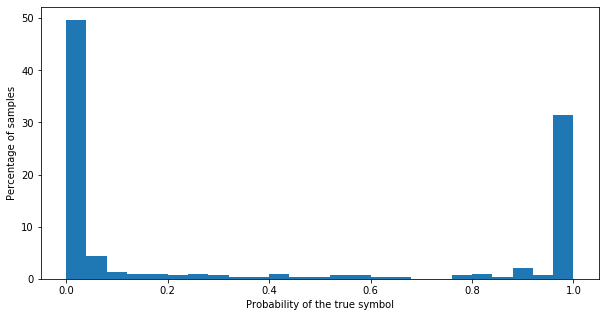

In [ ]:
wavenet_s_alignment_tester.alignment_pbb_chart()

Symbol * at position 0 was misclassified as 4.
Probability of the true symbol: 4.511813150734692e-14. Probability of 4: 1.0


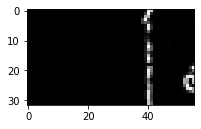

Symbol o at position 1 was misclassified as O.
Probability of the true symbol: 0.160996675491333. Probability of O: 0.6153579354286194


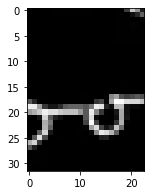

Symbol d at position 3 was misclassified as 2.
Probability of the true symbol: 0.0004693080554716289. Probability of 2: 0.3533742129802704


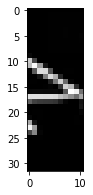

Symbol n at position 7 was misclassified as d.
Probability of the true symbol: 9.313517956854866e-09. Probability of d: 0.7647807598114014


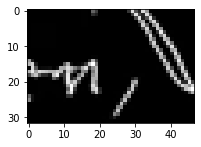

Symbol   at position 8 was misclassified as J.
Probability of the true symbol: 6.368678668877692e-07. Probability of J: 0.4920935332775116


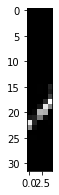

Symbol r at position 12 was misclassified as s.
Probability of the true symbol: 0.018825924023985863. Probability of s: 0.9088571667671204


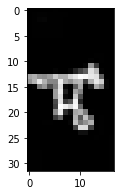

Symbol o at position 13 was misclassified as  .
Probability of the true symbol: 0.002561303088441491. Probability of  : 0.6998512148857117


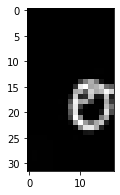

Symbol   at position 15 was misclassified as ,.
Probability of the true symbol: 0.00031104960362426937. Probability of ,: 0.5226724147796631


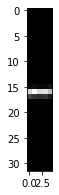

Symbol t at position 18 was misclassified as i.
Probability of the true symbol: 0.02048107609152794. Probability of i: 0.975336492061615


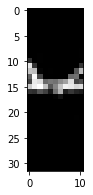

Symbol   at position 19 was misclassified as M.
Probability of the true symbol: 0.0013239835388958454. Probability of M: 0.6070278882980347


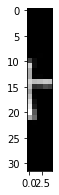

Symbol n at position 21 was misclassified as ,.
Probability of the true symbol: 2.7365481368034524e-14. Probability of ,: 0.9999982118606567


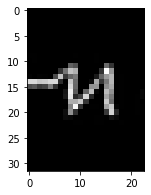

Symbol p at position 22 was misclassified as x.
Probability of the true symbol: 5.190431153931533e-29. Probability of x: 0.9881309270858765


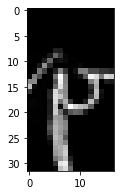

Symbol a at position 23 was misclassified as i.
Probability of the true symbol: 9.11212836955666e-14. Probability of i: 0.998806357383728


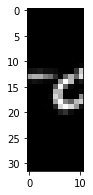

Symbol i at position 25 was misclassified as 2.
Probability of the true symbol: 0.00017179457063321024. Probability of 2: 0.9997342228889465


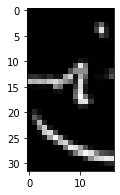

Symbol e at position 27 was misclassified as J.
Probability of the true symbol: 2.193412661866447e-17. Probability of J: 0.9815285205841064


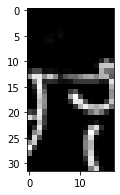

Symbol   at position 28 was misclassified as k.
Probability of the true symbol: 0.43795129656791687. Probability of k: 0.5085287690162659


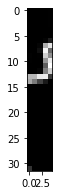

Symbol s at position 29 was misclassified as B.
Probability of the true symbol: 1.4911702428399565e-10. Probability of B: 0.9822678565979004


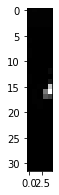

Symbol e at position 31 was misclassified as v.
Probability of the true symbol: 1.7802264551392e-07. Probability of v: 0.9996606111526489


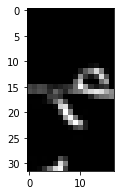

Symbol m at position 32 was misclassified as M.
Probability of the true symbol: 0.00012375657388474792. Probability of M: 0.9998762607574463


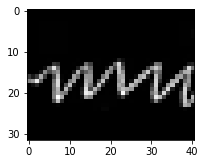

Symbol   at position 35 was misclassified as :.
Probability of the true symbol: 2.4430313771972578e-08. Probability of :: 0.975786566734314


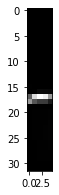

Symbol b at position 36 was misclassified as c.
Probability of the true symbol: 2.3383173055760217e-26. Probability of c: 0.9968724846839905


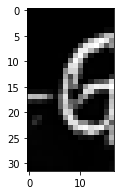

Symbol l at position 39 was misclassified as d.
Probability of the true symbol: 9.413344548292457e-10. Probability of d: 0.9753747582435608


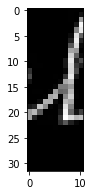

Symbol t at position 41 was misclassified as 5.
Probability of the true symbol: 0.008688999339938164. Probability of 5: 0.669669508934021


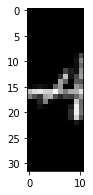

Symbol n at position 43 was misclassified as *.
Probability of the true symbol: 0.12714053690433502. Probability of *: 0.46551513671875


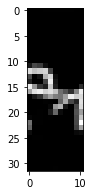

Symbol   at position 44 was misclassified as u.
Probability of the true symbol: 0.019607950001955032. Probability of u: 0.3706981837749481


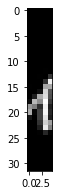

Symbol s at position 46 was misclassified as F.
Probability of the true symbol: 0.006708870641887188. Probability of F: 0.9235596060752869


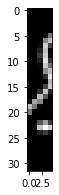

Symbol * at position 47 was misclassified as z.
Probability of the true symbol: 3.0005468595883933e-12. Probability of z: 1.0


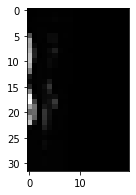

Symbol g at position 1 was misclassified as O.
Probability of the true symbol: 5.288771353662014e-05. Probability of O: 0.7514008283615112


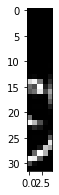

Symbol e at position 2 was misclassified as *.
Probability of the true symbol: 0.0002102110011037439. Probability of *: 0.961581289768219


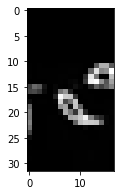

Symbol s at position 3 was misclassified as z.
Probability of the true symbol: 0.005776158068329096. Probability of z: 0.3430812358856201


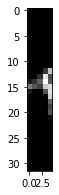

In [ ]:
wavenet_s_alignment_tester.show_badly_classified(30)

### larger Wavenet

In [ ]:
wavenet_l_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                       'wave_net': {
                                          'class_name': 'distsup.modules.wavenet.WaveNet',
                                       },
                                       'num_layers': 15,
                                       'hid_channels': 64,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_L_2019-12-09_18:22:39.pkl'
checkpoint = torch.load(model_serialize_path)
wavenet_l_rec.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
wavenet_l_trainer = ReconstructorTrainer(wavenet_l_rec, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_WaveNet_L",
               serialize_epochs=100,
               serialize_sample=None)

In [ ]:
wavenet_l_optim = optim.Adam(wavenet_l_rec.parameters(), lr=1e-3)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_WaveNet_large")

In [ ]:
wavenet_l_losses = wavenet_l_trainer.train(wavenet_l_optim, 100)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
AssertionError: can only join a child process
Traceback (most rece

Train Epoch: 1 [0/3852 (0%)]	Loss: 272328.375000
Train Epoch: 1 [3200/3852 (83%)]	Loss: 78693.218750


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 2 [0/3852 (0%)]	Loss: 76177.703125
Train Epoch: 2 [3200/3852 (83%)]	Loss: 63907.117188


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 3 [0/3852 (0%)]	Loss: 66432.320312
Train Epoch: 3 [3200/3852 (83%)]	Loss: 66342.117188


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Traceback (most recent call last):
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataload

Train Epoch: 4 [0/3852 (0%)]	Loss: 60410.277344
Train Epoch: 4 [3200/3852 (83%)]	Loss: 56789.371094


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == 

Train Epoch: 5 [0/3852 (0%)]	Loss: 65161.089844
Train Epoch: 5 [3200/3852 (83%)]	Loss: 59508.476562


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <bound method _MultiProcess

Train Epoch: 6 [0/3852 (0%)]	Loss: 61517.679688
Train Epoch: 6 [3200/3852 (83%)]	Loss: 56633.921875


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._p

Train Epoch: 7 [0/3852 (0%)]	Loss: 60212.687500
Train Epoch: 7 [3200/3852 (83%)]	Loss: 59109.566406


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
AssertionError: can only join a child process
  File "/usr/local/l

Train Epoch: 8 [0/3852 (0%)]	Loss: 60318.574219
Train Epoch: 8 [3200/3852 (83%)]	Loss: 58974.992188


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    w.join()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloade

Train Epoch: 9 [0/3852 (0%)]	Loss: 59869.878906
Train Epoch: 9 [3200/3852 (83%)]	Loss: 59360.894531


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
AssertionError: can only join a child process
  File "/usr/local/l

Train Epoch: 10 [0/3852 (0%)]	Loss: 55163.472656
Train Epoch: 10 [3200/3852 (83%)]	Loss: 54858.203125


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 11 [0/3852 (0%)]	Loss: 55643.679688
Train Epoch: 11 [3200/3852 (83%)]	Loss: 56309.324219


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 12 [0/3852 (0%)]	Loss: 57118.125000
Train Epoch: 12 [3200/3852 (83%)]	Loss: 53632.683594


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.

Train Epoch: 13 [0/3852 (0%)]	Loss: 58532.570312
Train Epoch: 13 [3200/3852 (83%)]	Loss: 50729.164062


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in

Train Epoch: 14 [0/3852 (0%)]	Loss: 53876.859375
Train Epoch: 14 [3200/3852 (83%)]	Loss: 50036.558594


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x

Train Epoch: 15 [0/3852 (0%)]	Loss: 53522.031250
Train Epoch: 15 [3200/3852 (83%)]	Loss: 54130.828125


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    w.join()
    assert self._p

Train Epoch: 16 [0/3852 (0%)]	Loss: 50315.214844
Train Epoch: 16 [3200/3852 (83%)]	Loss: 53249.554688


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 17 [0/3852 (0%)]	Loss: 53383.875000
Train Epoch: 17 [3200/3852 (83%)]	Loss: 51769.773438


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in

Train Epoch: 18 [0/3852 (0%)]	Loss: 55359.332031
Train Epoch: 18 [3200/3852 (83%)]	Loss: 50860.703125


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 19 [0/3852 (0%)]	Loss: 49538.000000
Train Epoch: 19 [3200/3852 (83%)]	Loss: 49812.320312


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 20 [0/3852 (0%)]	Loss: 48929.460938
Train Epoch: 20 [3200/3852 (83%)]	Loss: 50729.277344


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter

Train Epoch: 21 [0/3852 (0%)]	Loss: 53544.757812
Train Epoch: 21 [3200/3852 (83%)]	Loss: 48860.687500


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/lib/p

Train Epoch: 22 [0/3852 (0%)]	Loss: 49825.906250
Train Epoch: 22 [3200/3852 (83%)]	Loss: 48883.101562


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 23 [0/3852 (0%)]	Loss: 51381.488281
Train Epoch: 23 [3200/3852 (83%)]	Loss: 48643.398438


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    self._shutdown_workers()
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/da

Train Epoch: 24 [0/3852 (0%)]	Loss: 55831.828125
Train Epoch: 24 [3200/3852 (83%)]	Loss: 52994.117188


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in

Train Epoch: 25 [0/3852 (0%)]	Loss: 49610.281250
Train Epoch: 25 [3200/3852 (83%)]	Loss: 51063.195312


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/da

Train Epoch: 26 [0/3852 (0%)]	Loss: 51484.695312
Train Epoch: 26 [3200/3852 (83%)]	Loss: 51037.996094


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
AssertionError: can only join a child process
  File "/usr/local/l

Train Epoch: 27 [0/3852 (0%)]	Loss: 50057.394531
Train Epoch: 27 [3200/3852 (83%)]	Loss: 53376.828125


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in

Train Epoch: 28 [0/3852 (0%)]	Loss: 51193.679688
Train Epoch: 28 [3200/3852 (83%)]	Loss: 50749.148438


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
    w.join()
    self._shutdown_workers()
  File "/usr/loc

Train Epoch: 29 [0/3852 (0%)]	Loss: 49824.781250
Train Epoch: 29 [3200/3852 (83%)]	Loss: 49632.480469


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
    w.join()
  File "/usr/lib/python3.6/multiprocessing/pr

Train Epoch: 30 [0/3852 (0%)]	Loss: 53729.253906
Train Epoch: 30 [3200/3852 (83%)]	Loss: 49043.441406


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 31 [0/3852 (0%)]	Loss: 45839.531250
Train Epoch: 31 [3200/3852 (83%)]	Loss: 46932.765625


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
AssertionError: can only join a child process
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x

Train Epoch: 32 [0/3852 (0%)]	Loss: 43836.804688
Train Epoch: 32 [3200/3852 (83%)]	Loss: 49660.347656


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 33 [0/3852 (0%)]	Loss: 48680.960938
Train Epoch: 33 [3200/3852 (83%)]	Loss: 49478.019531


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 34 [0/3852 (0%)]	Loss: 49070.242188
Train Epoch: 34 [3200/3852 (83%)]	Loss: 51448.265625


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Traceback (most recent call last):
    w.join()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter obje

Train Epoch: 35 [0/3852 (0%)]	Loss: 46111.460938
Train Epoch: 35 [3200/3852 (83%)]	Loss: 45199.992188


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <bound method _MultiProcess

Train Epoch: 36 [0/3852 (0%)]	Loss: 45757.183594
Train Epoch: 36 [3200/3852 (83%)]	Loss: 46295.843750


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceb

Train Epoch: 37 [0/3852 (0%)]	Loss: 45884.890625
Train Epoch: 37 [3200/3852 (83%)]	Loss: 45989.582031


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 38 [0/3852 (0%)]	Loss: 50726.488281
Train Epoch: 38 [3200/3852 (83%)]	Loss: 47001.554688


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    w.join()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data

Train Epoch: 39 [0/3852 (0%)]	Loss: 49653.804688
Train Epoch: 39 [3200/3852 (83%)]	Loss: 46346.222656


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Traceback (most recent call last):
AssertionError: can only join a child process
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 40 [0/3852 (0%)]	Loss: 47918.593750
Train Epoch: 40 [3200/3852 (83%)]	Loss: 51017.660156


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x

Train Epoch: 41 [0/3852 (0%)]	Loss: 45141.718750
Train Epoch: 41 [3200/3852 (83%)]	Loss: 47901.734375


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound me

Train Epoch: 42 [0/3852 (0%)]	Loss: 48766.496094
Train Epoch: 42 [3200/3852 (83%)]	Loss: 46562.289062


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/da

Train Epoch: 43 [0/3852 (0%)]	Loss: 45749.812500
Train Epoch: 43 [3200/3852 (83%)]	Loss: 42636.726562


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 44 [0/3852 (0%)]	Loss: 49297.042969
Train Epoch: 44 [3200/3852 (83%)]	Loss: 47583.542969


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
    w.join()
    self._shutdown_workers()
  File "/usr/lib

Train Epoch: 45 [0/3852 (0%)]	Loss: 47787.335938
Train Epoch: 45 [3200/3852 (83%)]	Loss: 44753.992188


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 46 [0/3852 (0%)]	Loss: 51314.007812
Train Epoch: 46 [3200/3852 (83%)]	Loss: 45092.484375


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 47 [0/3852 (0%)]	Loss: 47051.449219
Train Epoch: 47 [3200/3852 (83%)]	Loss: 48197.867188


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils

Train Epoch: 48 [0/3852 (0%)]	Loss: 39724.703125
Train Epoch: 48 [3200/3852 (83%)]	Loss: 48769.300781


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
AssertionError: can only join a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 49 [0/3852 (0%)]	Loss: 44279.207031
Train Epoch: 49 [3200/3852 (83%)]	Loss: 45592.562500


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 50 [0/3852 (0%)]	Loss: 50849.304688
Train Epoch: 50 [3200/3852 (83%)]	Loss: 47659.945312


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    w.join()
  File "/usr/lib/p

Train Epoch: 51 [0/3852 (0%)]	Loss: 48867.160156
Train Epoch: 51 [3200/3852 (83%)]	Loss: 45228.843750


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x

Train Epoch: 52 [0/3852 (0%)]	Loss: 48761.644531
Train Epoch: 52 [3200/3852 (83%)]	Loss: 48876.812500


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/local/lib/python

Train Epoch: 53 [0/3852 (0%)]	Loss: 44884.554688
Train Epoch: 53 [3200/3852 (83%)]	Loss: 43771.578125


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/da

Train Epoch: 54 [0/3852 (0%)]	Loss: 45007.675781
Train Epoch: 54 [3200/3852 (83%)]	Loss: 42171.062500


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x

Train Epoch: 55 [0/3852 (0%)]	Loss: 46264.164062
Train Epoch: 55 [3200/3852 (83%)]	Loss: 49000.781250


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 56 [0/3852 (0%)]	Loss: 45896.691406
Train Epoch: 56 [3200/3852 (83%)]	Loss: 44761.937500


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    self._shutdown_workers()
Traceback (most recent call last):
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter ob

Train Epoch: 57 [0/3852 (0%)]	Loss: 43504.316406
Train Epoch: 57 [3200/3852 (83%)]	Loss: 42564.781250


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 58 [0/3852 (0%)]	Loss: 41581.039062
Train Epoch: 58 [3200/3852 (83%)]	Loss: 48137.316406


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a

Train Epoch: 59 [0/3852 (0%)]	Loss: 43822.070312
Train Epoch: 59 [3200/3852 (83%)]	Loss: 47971.972656


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 60 [0/3852 (0%)]	Loss: 48111.945312
Train Epoch: 60 [3200/3852 (83%)]	Loss: 48836.597656


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 61 [0/3852 (0%)]	Loss: 43064.812500
Train Epoch: 61 [3200/3852 (83%)]	Loss: 49582.976562


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    w.join()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 62 [0/3852 (0%)]	Loss: 47073.304688
Train Epoch: 62 [3200/3852 (83%)]	Loss: 47516.601562


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 63 [0/3852 (0%)]	Loss: 47231.054688
Train Epoch: 63 [3200/3852 (83%)]	Loss: 45479.492188


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/da

Train Epoch: 64 [0/3852 (0%)]	Loss: 45618.203125
Train Epoch: 64 [3200/3852 (83%)]	Loss: 47912.437500


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  Fi

Train Epoch: 65 [0/3852 (0%)]	Loss: 42910.125000
Train Epoch: 65 [3200/3852 (83%)]	Loss: 47206.207031


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 66 [0/3852 (0%)]	Loss: 46173.867188
Train Epoch: 66 [3200/3852 (83%)]	Loss: 45191.542969


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 67 [0/3852 (0%)]	Loss: 42320.414062
Train Epoch: 67 [3200/3852 (83%)]	Loss: 43182.621094


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 68 [0/3852 (0%)]	Loss: 43992.300781
Train Epoch: 68 [3200/3852 (83%)]	Loss: 45590.773438


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 69 [0/3852 (0%)]	Loss: 44264.496094
Train Epoch: 69 [3200/3852 (83%)]	Loss: 42391.789062


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 70 [0/3852 (0%)]	Loss: 46234.195312
Train Epoch: 70 [3200/3852 (83%)]	Loss: 47986.164062


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most rece

Train Epoch: 71 [0/3852 (0%)]	Loss: 42738.679688
Train Epoch: 71 [3200/3852 (83%)]	Loss: 42698.500000


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in

Train Epoch: 72 [0/3852 (0%)]	Loss: 47910.359375
Train Epoch: 72 [3200/3852 (83%)]	Loss: 50260.226562


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <bound method _MultiProcess

Train Epoch: 73 [0/3852 (0%)]	Loss: 47765.585938
Train Epoch: 73 [3200/3852 (83%)]	Loss: 45339.957031


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
    w.join()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataload

Train Epoch: 74 [0/3852 (0%)]	Loss: 44493.781250
Train Epoch: 74 [3200/3852 (83%)]	Loss: 45038.585938


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 75 [0/3852 (0%)]	Loss: 43392.957031
Train Epoch: 75 [3200/3852 (83%)]	Loss: 44594.000000


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
AssertionError: can only join a child process
  File "/usr/local/l

Train Epoch: 76 [0/3852 (0%)]	Loss: 42232.148438
Train Epoch: 76 [3200/3852 (83%)]	Loss: 46024.328125


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    w.join()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._p

Train Epoch: 77 [0/3852 (0%)]	Loss: 47633.476562
Train Epoch: 77 [3200/3852 (83%)]	Loss: 46476.843750


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Traceback (most recent call last):
    w.join()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
AssertionError: can only join a child process
  File "/usr/local/l

Train Epoch: 78 [0/3852 (0%)]	Loss: 43380.867188
Train Epoch: 78 [3200/3852 (83%)]	Loss: 44166.117188


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 79 [0/3852 (0%)]	Loss: 43335.503906
Train Epoch: 79 [3200/3852 (83%)]	Loss: 41451.347656


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del_

Train Epoch: 80 [0/3852 (0%)]	Loss: 39088.398438
Train Epoch: 80 [3200/3852 (83%)]	Loss: 44294.750000


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 81 [0/3852 (0%)]	Loss: 41550.421875
Train Epoch: 81 [3200/3852 (83%)]	Loss: 45556.097656


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in

Train Epoch: 82 [0/3852 (0%)]	Loss: 40625.593750
Train Epoch: 82 [3200/3852 (83%)]	Loss: 43030.648438


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data

Train Epoch: 83 [0/3852 (0%)]	Loss: 40324.812500
Train Epoch: 83 [3200/3852 (83%)]	Loss: 47156.890625


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del_

Train Epoch: 84 [0/3852 (0%)]	Loss: 46397.703125
Train Epoch: 84 [3200/3852 (83%)]	Loss: 46549.785156


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 85 [0/3852 (0%)]	Loss: 46185.378906
Train Epoch: 85 [3200/3852 (83%)]	Loss: 43552.703125


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/data

Train Epoch: 86 [0/3852 (0%)]	Loss: 40471.265625
Train Epoch: 86 [3200/3852 (83%)]	Loss: 43135.402344


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
AssertionError: can only join a child process
Exception ignored in

Train Epoch: 87 [0/3852 (0%)]	Loss: 41832.195312
Train Epoch: 87 [3200/3852 (83%)]	Loss: 43802.953125


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    assert self._parent_pid == 

Train Epoch: 88 [0/3852 (0%)]	Loss: 43654.554688
Train Epoch: 88 [3200/3852 (83%)]	Loss: 39078.750000


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in

Train Epoch: 89 [0/3852 (0%)]	Loss: 43203.476562
Train Epoch: 89 [3200/3852 (83%)]	Loss: 42864.023438


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/

Train Epoch: 90 [0/3852 (0%)]	Loss: 43780.113281
Train Epoch: 90 [3200/3852 (83%)]	Loss: 43972.351562


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 91 [0/3852 (0%)]	Loss: 43660.117188
Train Epoch: 91 [3200/3852 (83%)]	Loss: 46188.507812


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/lib/p

Train Epoch: 92 [0/3852 (0%)]	Loss: 46950.273438
Train Epoch: 92 [3200/3852 (83%)]	Loss: 45267.351562


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 93 [0/3852 (0%)]	Loss: 43506.117188
Train Epoch: 93 [3200/3852 (83%)]	Loss: 43818.757812


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
    self._shutdown_workers()
  File "/u

Train Epoch: 94 [0/3852 (0%)]	Loss: 47599.875000
Train Epoch: 94 [3200/3852 (83%)]	Loss: 45362.914062


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  File "/usr/local/l

Train Epoch: 95 [0/3852 (0%)]	Loss: 41637.601562
Train Epoch: 95 [3200/3852 (83%)]	Loss: 42017.960938


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  File "/usr/local/l

Train Epoch: 96 [0/3852 (0%)]	Loss: 42518.398438
Train Epoch: 96 [3200/3852 (83%)]	Loss: 43512.320312


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Train Epoch: 97 [0/3852 (0%)]	Loss: 42176.269531
Train Epoch: 97 [3200/3852 (83%)]	Loss: 41674.089844


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._p

Train Epoch: 98 [0/3852 (0%)]	Loss: 47805.214844
Train Epoch: 98 [3200/3852 (83%)]	Loss: 44648.367188


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <bound method _MultiProcess

Train Epoch: 99 [0/3852 (0%)]	Loss: 43854.910156
Train Epoch: 99 [3200/3852 (83%)]	Loss: 40244.554688


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7108edd9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    w.join()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == 

Train Epoch: 100 [0/3852 (0%)]	Loss: 43980.406250
Train Epoch: 100 [3200/3852 (83%)]	Loss: 42811.437500
Serializing model...
Model serialized as /content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_L_2019-12-09_18:22:39.pkl


In [ ]:
wavenet_l_alignment_tester = ModelAlignmentCoincidentTester(wavenet_l_rec, scribblelens_test_loader)

In [ ]:
wavenet_l_alignment_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 97 (0.32%)          	Miscalssified: 203 (0.68%)
Average probability assigned to the true symbol was: 0.32
Average probability assigned to the true symbol, when classified correctly was: 0.92
Average probability of most likely symbol while misclassifying was: 0.82
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 5
  '*': 5
  a: 6
  b: 1
  c: 2
  d: 1
  e: 29
  g: 3
  h: 3
  i: 2
  k: 2
  l: 5
  m: 1
  n: 6
  o: 3
  p: 2
  r: 5
  s: 2
  t: 8
  u: 2
  v: 4

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 37
  '*': 8
  ',': 3
  W: 2
  Z: 1
  a: 6
  b: 3
  c: 6
  d: 16
  e: 22
  f: 1
  g: 3
  h: 3
  i: 11
  j: 3
  k: 2
  l: 6
  m: 4
  n: 21
  o: 8
  p: 2
  r: 6
  s: 6
  t: 10
  u: 3
  w: 1
  x: 1
  y: 2
  z: 4
  "\xB4": 2

When classifying symbol * it's avg probability was: 0.4017555006801868
When classifying symbol e it's avg probability was: 0.5430427943062246
When classifying 

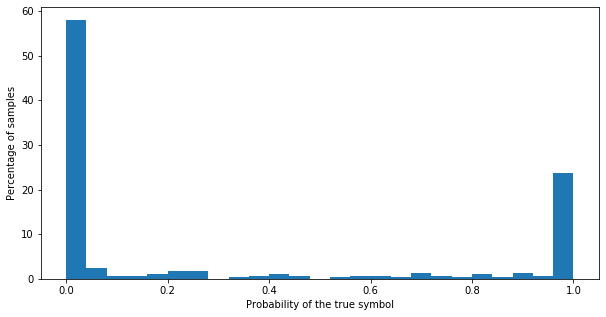

Histogram of highest assgined probability while processing each of symbols:


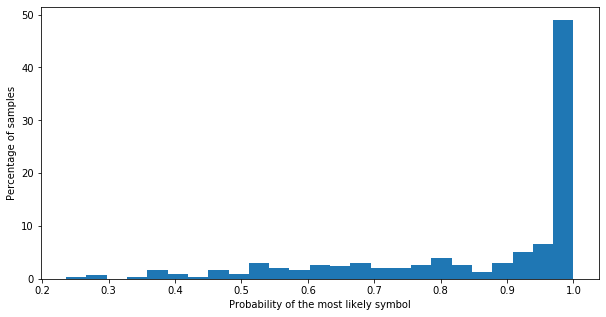

In [ ]:
wavenet_l_alignment_tester.summary()

In [ ]:
wavenet_l_alignment_tester.ignore(" ")

Classified samples: 260          	Classified correctly: 92 (0.35%)          	Miscalssified: 168 (0.65%)
Average probability assigned to the true symbol was: 0.36
Average probability assigned to the true symbol, when classified correctly was: 0.94
Average probability of most likely symbol while misclassifying was: 0.84
Symbols classified correctly: !!python/object/apply:collections.Counter
- '*': 5
  a: 6
  b: 1
  c: 2
  d: 1
  e: 29
  g: 3
  h: 3
  i: 2
  k: 2
  l: 5
  m: 1
  n: 6
  o: 3
  p: 2
  r: 5
  s: 2
  t: 8
  u: 2
  v: 4

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 2
  '*': 8
  ',': 3
  W: 2
  Z: 1
  a: 6
  b: 3
  c: 6
  d: 16
  e: 22
  f: 1
  g: 3
  h: 3
  i: 11
  j: 3
  k: 2
  l: 6
  m: 4
  n: 21
  o: 8
  p: 2
  r: 6
  s: 6
  t: 10
  u: 3
  w: 1
  x: 1
  y: 2
  z: 4
  "\xB4": 2

When classifying symbol * it's avg probability was: 0.4017555006801868
When classifying symbol e it's avg probability was: 0.5430427943062246
When classifying symbol l i

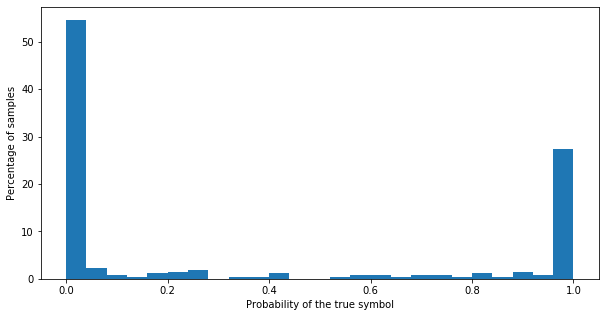

Histogram of highest assgined probability while processing each of symbols:


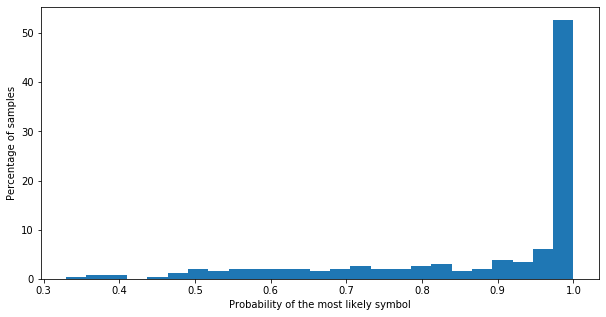

In [ ]:
wavenet_l_alignment_tester.summary()

### No aignment WaveNet

In [ ]:
wavenet_no_align_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                       'wave_net': {
                                          'class_name': 'distsup.modules.wavenet.WaveNet',
                                       },
                                       'num_layers': 15,
                                       'hid_channels': 64,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   ignore_alignment=True
                                   )

In [ ]:
no_align = wavenet_no_align_rec.transform_alignment(sample_test_cond.long()[None,:].to(device)).squeeze()

In [ ]:
torch.sum(no_align > 0)

tensor(0, device='cuda:0')

In [ ]:
wavenet_no_align_trainer = ReconstructorTrainer(wavenet_no_align_rec, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_WaveNet_no_align",
               serialize_epochs=100,
               serialize_sample=None)

In [ ]:
wavenet_no_align_optim = optim.Adam(wavenet_no_align_rec.parameters(), lr=1e-3)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_WaveNet_no_align")

In [ ]:
wavenet_no_align_losses = wavenet_no_align_trainer.train(wavenet_no_align_optim, 200)

Train Epoch: 1 [0/3852 (0%)]	Loss: 271995.500000
Train Epoch: 1 [3200/3852 (83%)]	Loss: 72183.789062
Train Epoch: 2 [0/3852 (0%)]	Loss: 68106.914062
Train Epoch: 2 [3200/3852 (83%)]	Loss: 69591.546875
Train Epoch: 3 [0/3852 (0%)]	Loss: 62401.691406
Train Epoch: 3 [3200/3852 (83%)]	Loss: 65534.023438
Train Epoch: 4 [0/3852 (0%)]	Loss: 59134.230469
Train Epoch: 4 [3200/3852 (83%)]	Loss: 66045.687500
Train Epoch: 5 [0/3852 (0%)]	Loss: 63094.773438
Train Epoch: 5 [3200/3852 (83%)]	Loss: 58932.824219
Train Epoch: 6 [0/3852 (0%)]	Loss: 60398.000000
Train Epoch: 6 [3200/3852 (83%)]	Loss: 54707.855469
Train Epoch: 7 [0/3852 (0%)]	Loss: 53681.328125
Train Epoch: 7 [3200/3852 (83%)]	Loss: 59240.812500
Train Epoch: 8 [0/3852 (0%)]	Loss: 56578.187500
Train Epoch: 8 [3200/3852 (83%)]	Loss: 58263.941406
Train Epoch: 9 [0/3852 (0%)]	Loss: 51469.601562
Train Epoch: 9 [3200/3852 (83%)]	Loss: 51381.000000
Train Epoch: 10 [0/3852 (0%)]	Loss: 52655.867188
Train Epoch: 10 [3200/3852 (83%)]	Loss: 55588.5546

### Lookahead

In [ ]:
wavenet_lookahead_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.LookaheadColumnwiseWaveNet',
                                       'hid_channels': 64,
                                       'ahead_frames': 5,
                                       'ahead_corruption': None,
                                       'ahead_fraction': 0.5,
                                       'bidirectional': False,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_lookahead_2019-12-12_19:32:22.pkl'
checkpoint = torch.load(model_serialize_path)
wavenet_lookahead_rec.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
wavenet_lookahead_trainer = ReconstructorTrainer(wavenet_lookahead_rec, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_WaveNet_lookahead",
               serialize_epochs=150,
               serialize_sample=None)

In [ ]:
wavenet_lookahead_optim = optim.Adam(wavenet_lookahead_rec.parameters(), lr=1e-3)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_WaveNet_lookahead")

In [ ]:
wavenet_lookahead_losses = wavenet_lookahead_trainer.train(wavenet_lookahead_optim, 150)

Train Epoch: 1 [0/3852 (0%)]	Loss: 56147.558594
Train Epoch: 1 [3200/3852 (83%)]	Loss: 66241.507812
Train Epoch: 2 [0/3852 (0%)]	Loss: 63939.933594
Train Epoch: 2 [3200/3852 (83%)]	Loss: 50439.320312
Train Epoch: 3 [0/3852 (0%)]	Loss: 50063.296875
Train Epoch: 3 [3200/3852 (83%)]	Loss: 70255.304688
Train Epoch: 4 [0/3852 (0%)]	Loss: 66617.523438
Train Epoch: 4 [3200/3852 (83%)]	Loss: 48102.925781
Train Epoch: 5 [0/3852 (0%)]	Loss: 49552.414062
Train Epoch: 5 [3200/3852 (83%)]	Loss: 51690.992188
Train Epoch: 6 [0/3852 (0%)]	Loss: 66151.500000
Train Epoch: 6 [3200/3852 (83%)]	Loss: 74497.906250
Train Epoch: 7 [0/3852 (0%)]	Loss: 51223.273438
Train Epoch: 7 [3200/3852 (83%)]	Loss: 62409.437500
Train Epoch: 8 [0/3852 (0%)]	Loss: 66669.554688
Train Epoch: 8 [3200/3852 (83%)]	Loss: 62648.488281
Train Epoch: 9 [0/3852 (0%)]	Loss: 50481.015625
Train Epoch: 9 [3200/3852 (83%)]	Loss: 64178.742188
Train Epoch: 10 [0/3852 (0%)]	Loss: 63684.101562
Train Epoch: 10 [3200/3852 (83%)]	Loss: 65311.94140

In [ ]:
wavenet_lookahead_alignment_tester = ModelAlignmentCoincidentTester(wavenet_lookahead_rec, scribblelens_test_loader)

In [ ]:
wavenet_lookahead_alignment_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 63 (0.21%)          	Miscalssified: 237 (0.79%)
Average probability assigned to the true symbol was: 0.20923595281645513
Average probability assigned to the true symbol, when classified correctly was: 0.9451045091190036
Average probability of most likely symbol while misclassifying was: 0.8670444488525391
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 4
  '*': 3
  W: 1
  a: 4
  d: 4
  e: 13
  g: 1
  h: 3
  i: 2
  k: 1
  l: 3
  n: 11
  o: 2
  p: 1
  r: 3
  s: 1
  t: 3
  u: 1
  w: 1
  y: 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 38
  '*': 10
  ',': 3
  W: 1
  Z: 1
  a: 8
  b: 4
  c: 8
  d: 13
  e: 38
  f: 1
  g: 5
  h: 3
  i: 11
  j: 3
  k: 3
  l: 8
  m: 5
  n: 16
  o: 9
  p: 3
  r: 8
  s: 7
  t: 15
  u: 4
  v: 4
  x: 1
  y: 1
  z: 4
  "\xB4": 2

When classifying symbol W it's avg probability was: 0.500158173716045
When classifying symbol r it's avg probability was:

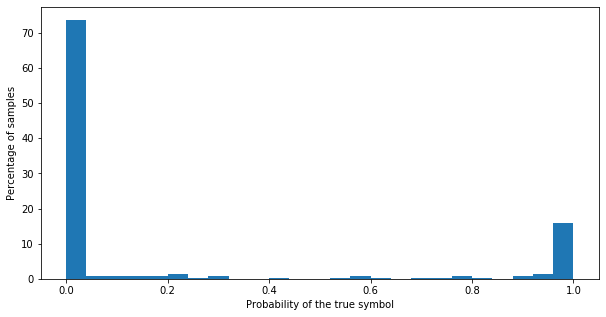

Histogram of highest assgined probability while processing each of symbols:


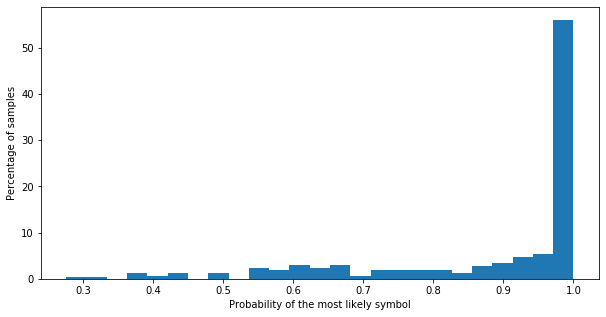

In [ ]:
wavenet_lookahead_alignment_tester.summary()

### Lookahead small ahead

In [ ]:
wavenet_lookahead_s_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.LookaheadColumnwiseWaveNet',
                                       'hid_channels': 64,
                                       'ahead_frames': 2,
                                       'ahead_corruption': None,
                                       'ahead_fraction': 0.1,
                                       'bidirectional': False,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_lookahead_s_2019-12-12_15:41:18.pkl'
checkpoint = torch.load(model_serialize_path)
wavenet_lookahead_s_rec.load_state_dict(checkpoint['model_state_dict'])

NameError: ignored

In [ ]:
wavenet_lookahead_s_trainer = ReconstructorTrainer(wavenet_lookahead_s_rec, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_WaveNet_lookahead_s",
               serialize_epochs=150,
               serialize_sample=None)

In [ ]:
wavenet_lookahead_s_optim = optim.Adam(wavenet_lookahead_s_rec.parameters(), lr=1e-3)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_WaveNet_lookahead_s")

In [ ]:
wavenet_lookahead_s_losses = wavenet_lookahead_s_trainer.train(wavenet_lookahead_s_optim, 150)

Train Epoch: 1 [0/3852 (0%)]	Loss: 273106.843750
Train Epoch: 1 [3200/3852 (83%)]	Loss: 68162.304688
Train Epoch: 2 [0/3852 (0%)]	Loss: 79236.437500
Train Epoch: 2 [3200/3852 (83%)]	Loss: 75597.187500
Train Epoch: 3 [0/3852 (0%)]	Loss: 71493.515625
Train Epoch: 3 [3200/3852 (83%)]	Loss: 68506.250000
Train Epoch: 4 [0/3852 (0%)]	Loss: 59764.257812
Train Epoch: 4 [3200/3852 (83%)]	Loss: 63894.691406
Train Epoch: 5 [0/3852 (0%)]	Loss: 60359.757812
Train Epoch: 5 [3200/3852 (83%)]	Loss: 59030.226562
Train Epoch: 6 [0/3852 (0%)]	Loss: 59997.523438
Train Epoch: 6 [3200/3852 (83%)]	Loss: 60011.859375
Train Epoch: 7 [0/3852 (0%)]	Loss: 62550.296875
Train Epoch: 7 [3200/3852 (83%)]	Loss: 51967.757812
Train Epoch: 8 [0/3852 (0%)]	Loss: 60771.906250
Train Epoch: 8 [3200/3852 (83%)]	Loss: 56771.886719
Train Epoch: 9 [0/3852 (0%)]	Loss: 75416.218750
Train Epoch: 9 [3200/3852 (83%)]	Loss: 56529.460938
Train Epoch: 10 [0/3852 (0%)]	Loss: 59832.445312
Train Epoch: 10 [3200/3852 (83%)]	Loss: 56200.3359

In [ ]:
wavenet_lookahead_s_alignment_tester = ModelAlignmentCoincidentTester(wavenet_lookahead_s_rec, scribblelens_test_loader)

In [ ]:
wavenet_lookahead_s_alignment_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 2 (0.01%)          	Miscalssified: 298 (0.99%)
Average probability assigned to the true symbol was: 0.02
Average probability assigned to the true symbol, when classified correctly was: 0.03
Average probability of most likely symbol while misclassifying was: 0.06
Symbols classified correctly: !!python/object/apply:collections.Counter
- a: 2

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 42
  '*': 13
  ',': 3
  W: 2
  Z: 1
  a: 10
  b: 4
  c: 8
  d: 17
  e: 51
  f: 1
  g: 6
  h: 6
  i: 13
  j: 3
  k: 4
  l: 11
  m: 5
  n: 27
  o: 11
  p: 4
  r: 11
  s: 8
  t: 18
  u: 5
  v: 4
  w: 1
  x: 1
  y: 2
  z: 4
  "\xB4": 2

When classifying symbol a it's avg probability was: 0.02239046028504769
When classifying symbol * it's avg probability was: 0.005956962355412543
When classifying symbol o it's avg probability was: 0.0138331674547358
When classifying symbol r it's avg probability was: 0.011572711381383917
When

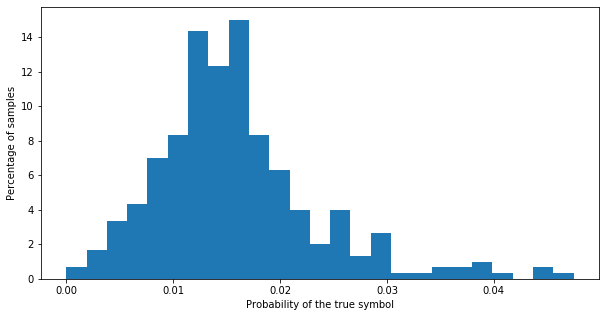

Histogram of highest assgined probability while processing each of symbols:


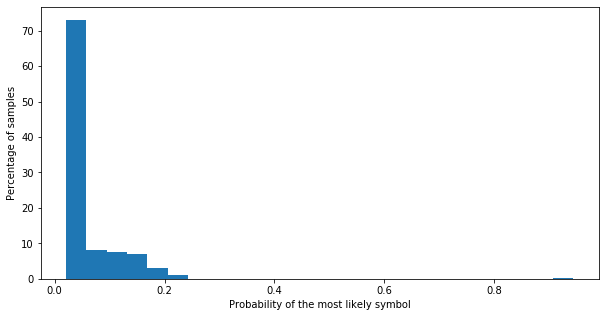

In [ ]:
wavenet_lookahead_s_alignment_tester.summary()

### Lookahead no alignmnet

In [ ]:
wavenet_lookahead_rec_no_align = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.LookaheadColumnwiseWaveNet',
                                       'hid_channels': 64,
                                       'ahead_frames': 5,
                                       'ahead_corruption': None,
                                       'ahead_fraction': 0.5,
                                       'bidirectional': False,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   ignore_alignment=True
                                   )

In [ ]:
wavenet_lookahead_na_trainer = ReconstructorTrainer(wavenet_lookahead_rec_no_align, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_WaveNet_lookahead_no_align",
               serialize_epochs=100,
               serialize_sample=None)

In [ ]:
wavenet_lookahead_na_optim = optim.Adam(wavenet_lookahead_rec_no_align.parameters(), lr=1e-3)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_WaveNet_lookahead_no_align")

In [ ]:
wavenet_lookahead_na_losses = wavenet_lookahead_na_trainer.train(wavenet_lookahead_na_optim, 200)

Train Epoch: 1 [0/3852 (0%)]	Loss: 272692.687500
Train Epoch: 1 [3200/3852 (83%)]	Loss: 74350.250000
Train Epoch: 2 [0/3852 (0%)]	Loss: 74430.148438
Train Epoch: 2 [3200/3852 (83%)]	Loss: 75595.187500
Train Epoch: 3 [0/3852 (0%)]	Loss: 68414.031250
Train Epoch: 3 [3200/3852 (83%)]	Loss: 78657.296875
Train Epoch: 4 [0/3852 (0%)]	Loss: 62617.585938
Train Epoch: 4 [3200/3852 (83%)]	Loss: 70756.632812
Train Epoch: 5 [0/3852 (0%)]	Loss: 71303.945312
Train Epoch: 5 [3200/3852 (83%)]	Loss: 66800.453125
Train Epoch: 6 [0/3852 (0%)]	Loss: 69934.679688
Train Epoch: 6 [3200/3852 (83%)]	Loss: 77454.773438
Train Epoch: 7 [0/3852 (0%)]	Loss: 78859.757812
Train Epoch: 7 [3200/3852 (83%)]	Loss: 67528.335938
Train Epoch: 8 [0/3852 (0%)]	Loss: 78467.945312
Train Epoch: 8 [3200/3852 (83%)]	Loss: 65607.421875
Train Epoch: 9 [0/3852 (0%)]	Loss: 81039.453125
Train Epoch: 9 [3200/3852 (83%)]	Loss: 64423.273438
Train Epoch: 10 [0/3852 (0%)]	Loss: 74754.562500
Train Epoch: 10 [3200/3852 (83%)]	Loss: 59497.3398

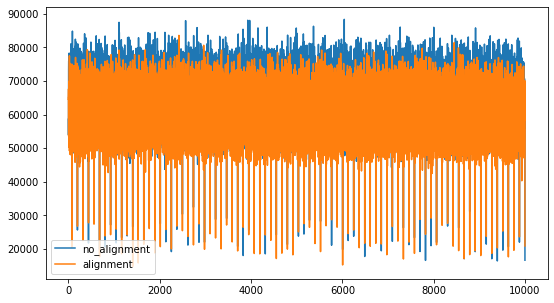

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(np.arange(10000), wavenet_lookahead_na_losses[-10000:], label="no_alignment")
plt.plot(np.arange(10000), wavenet_lookahead_losses[-10000:], label="alignment")
plt.legend()

## Other reconstructors

### Decoder 2D

In [ ]:
decoder_2d_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.Decoder_2d',
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_decoder_2d_2019-12-12_21:06:09.pkl'
checkpoint = torch.load(model_serialize_path)
decoder_2d_rec.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
decoder_2d_trainer = ReconstructorTrainer(decoder_2d_rec, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_decoder_2d",
               serialize_epochs=150,
               serialize_sample=None)

In [ ]:
decoder_2d_optim = optim.Adam(decoder_2d_rec.parameters(), lr=1e-4)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_decoder_2d")

In [ ]:
decoder_2d_losses = decoder_2d_trainer.train(decoder_2d_optim, 150)

Train Epoch: 1 [0/3852 (0%)]	Loss: 7558.506348
Train Epoch: 1 [3200/3852 (83%)]	Loss: 7102.136719
Train Epoch: 2 [0/3852 (0%)]	Loss: 6893.293945
Train Epoch: 2 [3200/3852 (83%)]	Loss: 7016.513184
Train Epoch: 3 [0/3852 (0%)]	Loss: 6963.990723
Train Epoch: 3 [3200/3852 (83%)]	Loss: 6619.463867
Train Epoch: 4 [0/3852 (0%)]	Loss: 7225.197266
Train Epoch: 4 [3200/3852 (83%)]	Loss: 6789.193359
Train Epoch: 5 [0/3852 (0%)]	Loss: 7285.917969
Train Epoch: 5 [3200/3852 (83%)]	Loss: 6341.393555
Train Epoch: 6 [0/3852 (0%)]	Loss: 7628.024414
Train Epoch: 6 [3200/3852 (83%)]	Loss: 6838.703125
Train Epoch: 7 [0/3852 (0%)]	Loss: 7075.296875
Train Epoch: 7 [3200/3852 (83%)]	Loss: 7247.458984
Train Epoch: 8 [0/3852 (0%)]	Loss: 7387.779297
Interrupting...


In [ ]:
sample_test_cond_transformed = decoder_2d_rec.transform_alignment(sample_test_cond.long()[None,:].to(device))

In [ ]:
dec2d_out = decoder_2d_rec.reconstructor(sample_test_img[None,:], sample_test_cond_transformed)

In [ ]:
dec2d_out.shape

torch.Size([207, 4, 32, 1, 16])

In [ ]:
dec2d_out = dec2d_out.reshape(-1, dec2d_out.size(2), dec2d_out.size(-1))

In [ ]:
dec2d_out.shape

torch.Size([828, 32, 16])

(array([    0.,     0.,     0.,     0.,     0., 26496.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

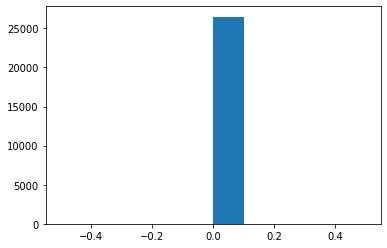

In [ ]:
plt.hist(torch.argmax(dec2d_out, -1).view(-1).cpu())

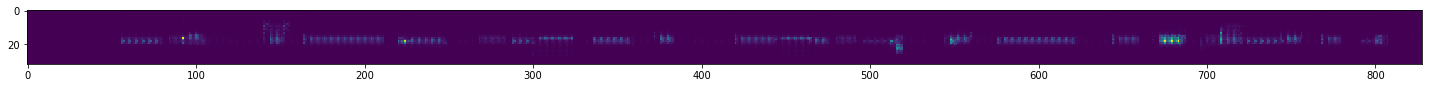

In [ ]:
plt.figure(figsize=(25,5))
plt.imshow(dec2d_out.data.cpu().transpose(0,1))

In [ ]:
decoder_2d_alignment_tester = ModelAlignmentCoincidentTester(decoder_2d_rec, scribblelens_test_loader)

In [ ]:
decoder_2d_alignment_tester.test_alignment_image_relation(100)

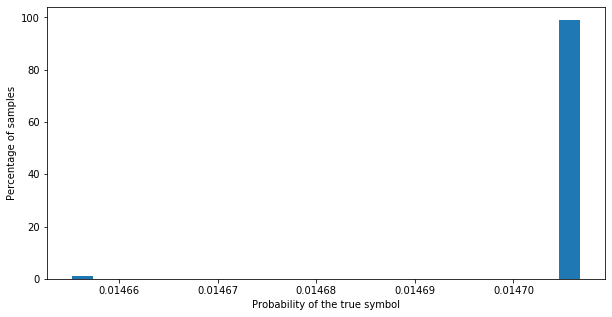

In [ ]:
decoder_2d_alignment_tester.alignment_pbb_chart()

### Upsampling Conv 2d

In [ ]:
upsampling_conv_2d_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   len_reduction=1,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.UpsamplingConv2d',
                                    },
                                   count_blanks_alignment=False,
                                   )

In [ ]:
upsampling_conv_2d_trainer = ReconstructorTrainer(upsampling_conv_2d_rec, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_upsampling_conv_2d",
               serialize_epochs=150,
               serialize_sample=None)

In [ ]:
upsampling_conv_2d_optim = optim.Adam(upsampling_conv_2d_rec.parameters(), lr=1e-4)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_upsampling_conv_2d")

In [ ]:
upsampling_conv_2d_losses = upsampling_conv_2d_trainer.train(upsampling_conv_2d_optim, 150)

Train Epoch: 1 [0/3852 (0%)]	Loss: 11764.638672
Train Epoch: 1 [3200/3852 (83%)]	Loss: 11789.224609
Train Epoch: 2 [0/3852 (0%)]	Loss: 11752.306641
Train Epoch: 2 [3200/3852 (83%)]	Loss: 11702.906250
Train Epoch: 3 [0/3852 (0%)]	Loss: 11234.292969
Train Epoch: 3 [3200/3852 (83%)]	Loss: 11444.472656
Train Epoch: 4 [0/3852 (0%)]	Loss: 11316.443359
Train Epoch: 4 [3200/3852 (83%)]	Loss: 11316.972656
Train Epoch: 5 [0/3852 (0%)]	Loss: 10711.490234
Train Epoch: 5 [3200/3852 (83%)]	Loss: 11488.543945
Train Epoch: 6 [0/3852 (0%)]	Loss: 11749.363281
Train Epoch: 6 [3200/3852 (83%)]	Loss: 11167.338867
Train Epoch: 7 [0/3852 (0%)]	Loss: 11269.535156
Train Epoch: 7 [3200/3852 (83%)]	Loss: 11450.851562
Train Epoch: 8 [0/3852 (0%)]	Loss: 11160.859375
Train Epoch: 8 [3200/3852 (83%)]	Loss: 11159.982422
Train Epoch: 9 [0/3852 (0%)]	Loss: 11282.814453
Train Epoch: 9 [3200/3852 (83%)]	Loss: 11668.765625
Train Epoch: 10 [0/3852 (0%)]	Loss: 11206.401367
Train Epoch: 10 [3200/3852 (83%)]	Loss: 10942.69921

In [ ]:
upsampling_conv_2d_rec

OneHotReconstructor(
  (reconstructor): UpsamplingConv2d(
    (quantizer): L1Loss()
    (conv): Conv1d(68, 2048, kernel_size=(1,), stride=(1,))
    (decoder): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
      (4): Sigmoid()
    )
  )
)

In [ ]:
torch.sum(upsampling_conv_2d_rec.reconstructor.get_inputs_and_targets(sample_test_img[None,:])[1] != sample_test_img[None,:])

tensor(0)

In [ ]:
sample_test_cond_transformed = upsampling_conv_2d_rec.transform_alignment(sample_test_cond[None,:].long().to(device))

In [ ]:
up2out = upsampling_conv_2d_rec.reconstructor(sample_test_img[None,:], sample_test_cond_transformed)

In [ ]:
up2out.shape

torch.Size([828, 1, 32, 1, 1])

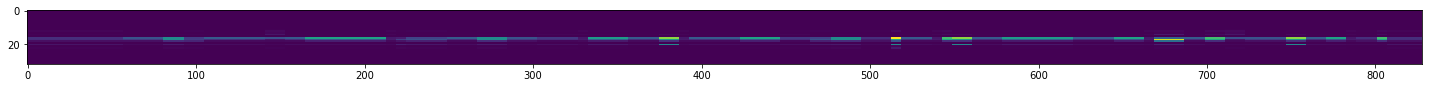

In [ ]:
plt.figure(figsize=(25,5))
plt.imshow(up2out.squeeze().data.cpu().transpose(0,1))

### Stack reconstructor

In [ ]:
stack_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   len_reduction=1,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.StackReconstructor',
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                        },
                                    },
                                   count_blanks_alignment=False,
                                   )

In [ ]:
stack_rec_trainer = ReconstructorTrainer(stack_rec, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_stack_rec",
               serialize_epochs=150,
               serialize_sample=None)

In [ ]:
stack_rec_optim = optim.Adam(stack_rec.parameters(), lr=1e-3)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_stack_rec")

In [ ]:
stack_rec_losses = stack_rec_trainer.train(stack_rec_optim, 150)

Train Epoch: 1 [0/3852 (0%)]	Loss: 271860.750000
Train Epoch: 1 [3200/3852 (83%)]	Loss: 82740.953125
Train Epoch: 2 [0/3852 (0%)]	Loss: 85723.734375
Train Epoch: 2 [3200/3852 (83%)]	Loss: 76993.171875
Train Epoch: 3 [0/3852 (0%)]	Loss: 81976.484375
Train Epoch: 3 [3200/3852 (83%)]	Loss: 76956.218750
Train Epoch: 4 [0/3852 (0%)]	Loss: 80409.406250
Train Epoch: 4 [3200/3852 (83%)]	Loss: 77570.515625
Train Epoch: 5 [0/3852 (0%)]	Loss: 73520.359375
Train Epoch: 5 [3200/3852 (83%)]	Loss: 72683.210938
Train Epoch: 6 [0/3852 (0%)]	Loss: 80760.187500
Train Epoch: 6 [3200/3852 (83%)]	Loss: 72576.015625
Train Epoch: 7 [0/3852 (0%)]	Loss: 77920.250000
Train Epoch: 7 [3200/3852 (83%)]	Loss: 82662.625000
Train Epoch: 8 [0/3852 (0%)]	Loss: 82362.859375
Train Epoch: 8 [3200/3852 (83%)]	Loss: 78801.757812
Train Epoch: 9 [0/3852 (0%)]	Loss: 80412.609375
Train Epoch: 9 [3200/3852 (83%)]	Loss: 80870.234375
Train Epoch: 10 [0/3852 (0%)]	Loss: 76704.195312
Train Epoch: 10 [3200/3852 (83%)]	Loss: 77860.9062

In [ ]:
stack_rec_trainer.serialize(79, stack_rec_optim)

Model serialized as /content/drive/My Drive/master_thesis/models/Scribblelens_stack_rec_2019-12-14_17:24:31.pkl


In [ ]:
stack_rec_tester = ModelAlignmentCoincidentTester(stack_rec, scribblelens_test_loader)

In [ ]:
stack_rec_tester.test_alignment_image_relation(100)

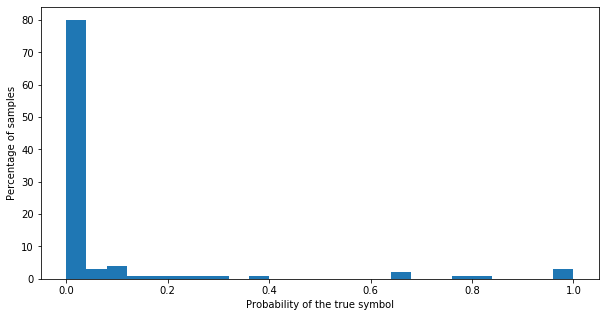

In [ ]:
stack_rec_tester.alignment_pbb_chart()

In [ ]:
stack_rec_all_classified = stack_rec_tester.correctly_classified + stack_rec_tester.badly_classified

In [ ]:
len(stack_rec_tester.correctly_classified) / len(stack_rec_all_classified)

0.08

### Two way reconstructor

In [ ]:
double_pixelcnn_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'lr': {
                                            'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                                'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                                'num_levels': 16
                                            },
                                            'n_layers': 4,
                                        },
                                        'rl': {
                                            'class_name': 'distsup.modules.reconstructors.RightToLeftReconstructor',
                                            'wrapped_class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                              'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                              'num_levels': 16
                                            },
                                            'n_layers': 4
                                        }
                                   },
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_doulbe_pixelcnn_2019-12-15_13:14:16.pkl'
checkpoint = torch.load(model_serialize_path)
double_pixelcnn_rec.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
double_pixelcnn_trainer = ReconstructorTrainer(double_pixelcnn_rec, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_doulbe_pixelcnn",
               serialize_epochs=100,
               serialize_sample=None)

In [ ]:
double_pixelcnn_rec_optim = optim.Adam(double_pixelcnn_rec.parameters(), lr=1e-3)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_double_pixelcnn_rec")

In [ ]:
double_pixelcnn_rec_losses = double_pixelcnn_trainer.train(double_pixelcnn_rec_optim, 200)

Train Epoch: 1 [0/3852 (0%)]	Loss: 78895.851562
Train Epoch: 1 [3200/3852 (83%)]	Loss: 80528.195312
Train Epoch: 2 [0/3852 (0%)]	Loss: 76647.210938
Train Epoch: 2 [3200/3852 (83%)]	Loss: 76013.843750
Train Epoch: 3 [0/3852 (0%)]	Loss: 76454.546875
Train Epoch: 3 [3200/3852 (83%)]	Loss: 81357.968750
Train Epoch: 4 [0/3852 (0%)]	Loss: 77915.843750
Train Epoch: 4 [3200/3852 (83%)]	Loss: 83875.625000
Train Epoch: 5 [0/3852 (0%)]	Loss: 77560.554688
Train Epoch: 5 [3200/3852 (83%)]	Loss: 72475.757812
Train Epoch: 6 [0/3852 (0%)]	Loss: 79190.203125
Train Epoch: 6 [3200/3852 (83%)]	Loss: 74032.250000
Train Epoch: 7 [0/3852 (0%)]	Loss: 75216.203125
Train Epoch: 7 [3200/3852 (83%)]	Loss: 71353.000000
Train Epoch: 8 [0/3852 (0%)]	Loss: 81868.312500
Train Epoch: 8 [3200/3852 (83%)]	Loss: 79228.921875
Train Epoch: 9 [0/3852 (0%)]	Loss: 80210.875000
Train Epoch: 9 [3200/3852 (83%)]	Loss: 76878.828125
Train Epoch: 10 [0/3852 (0%)]	Loss: 75927.078125
Train Epoch: 10 [3200/3852 (83%)]	Loss: 79738.07031

In [ ]:
double_pixelcnn_trainer.serialize(80, double_pixelcnn_rec_optim)

Model serialized as /content/drive/My Drive/master_thesis/models/Scribblelens_doulbe_pixelcnn_2019-12-15_13:14:16.pkl


In [ ]:
double_pixelcnn_rec_tester = ModelAlignmentCoincidentTester(double_pixelcnn_rec, scribblelens_test_loader)

In [ ]:
double_pixelcnn_rec_tester.test_alignment_image_relation(200)

Classified samples: 200          	Classified correctly: 29 (0.14%)          	Miscalssified: 171 (0.85%)
Average probability assigned to the true symbol was: 0.1481143530279128
Average probability assigned to the true symbol, when classified correctly was: 0.8107997415394619
Average probability of most likely symbol while misclassifying was: 0.6903522610664368
Symbols classified correctly: !!python/object/apply:collections.Counter
- a: 1
  b: 1
  e: 6
  g: 2
  h: 2
  i: 1
  j: 1
  k: 2
  l: 6
  n: 1
  p: 1
  r: 3
  s: 1
  v: 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 29
  '*': 9
  ',': 2
  W: 1
  a: 7
  b: 3
  c: 5
  d: 10
  e: 28
  g: 2
  i: 6
  j: 2
  k: 1
  l: 2
  m: 3
  n: 14
  o: 8
  p: 1
  r: 6
  s: 6
  t: 13
  u: 3
  v: 2
  w: 1
  x: 1
  y: 1
  z: 4
  "\xB4": 1

When classifying symbol l it's avg probability was: 0.5973318801043206
When classifying symbol p it's avg probability was: 0.5015644847881049
When classifying symbol i it's avg probabili

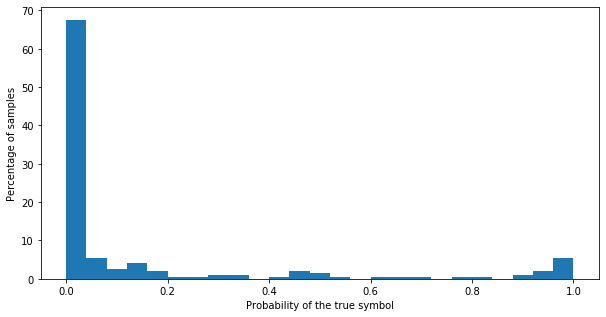

Histogram of highest assgined probability while processing each of symbols:


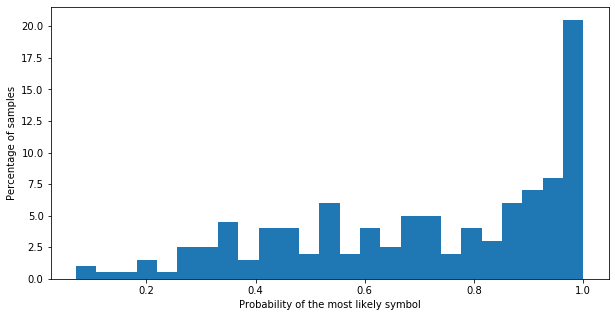

In [ ]:
double_pixelcnn_rec_tester.summary()

In [ ]:
double_pixelcnn_rec_tester.ignore(" ")

Classified samples: 172          	Classified correctly: 29 (0.17%)          	Miscalssified: 143 (0.83%)
Average probability assigned to the true symbol was: 0.17157572125753753
Average probability assigned to the true symbol, when classified correctly was: 0.8107997415394619
Average probability of most likely symbol while misclassifying was: 0.7229086756706238
Symbols classified correctly: !!python/object/apply:collections.Counter
- a: 1
  b: 1
  e: 6
  g: 2
  h: 2
  i: 1
  j: 1
  k: 2
  l: 6
  n: 1
  p: 1
  r: 3
  s: 1
  v: 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 1
  '*': 9
  ',': 2
  W: 1
  a: 7
  b: 3
  c: 5
  d: 10
  e: 28
  g: 2
  i: 6
  j: 2
  k: 1
  l: 2
  m: 3
  n: 14
  o: 8
  p: 1
  r: 6
  s: 6
  t: 13
  u: 3
  v: 2
  w: 1
  x: 1
  y: 1
  z: 4
  "\xB4": 1

When classifying symbol l it's avg probability was: 0.5973318801043206
When classifying symbol p it's avg probability was: 0.5015644847881049
When classifying symbol i it's avg probabili

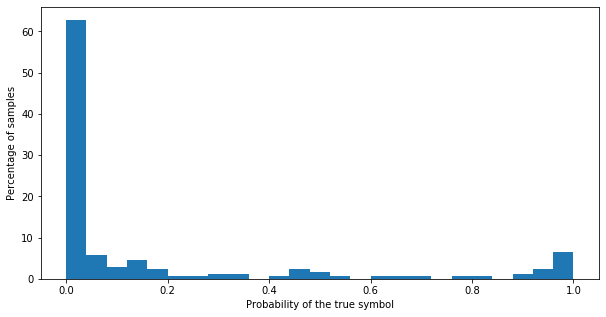

Histogram of highest assgined probability while processing each of symbols:


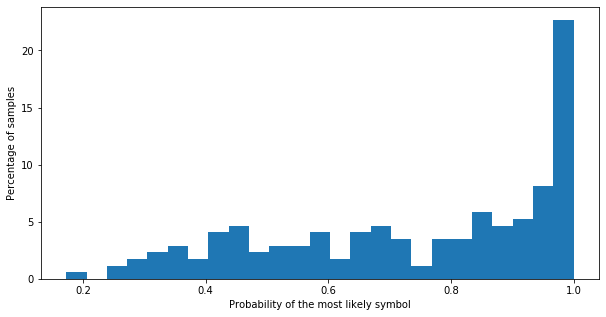

In [ ]:
double_pixelcnn_rec_tester.summary()

### Larger bidirectional

In [ ]:
double_pixelcnn_rec_l = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'lr': {
                                            'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                                'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                                'num_levels': 16
                                            },
                                            'n_layers': 7,
                                        },
                                        'rl': {
                                            'class_name': 'distsup.modules.reconstructors.RightToLeftReconstructor',
                                            'wrapped_class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                              'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                              'num_levels': 16
                                            },
                                            'n_layers': 7
                                        }
                                   },
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_doulbe_pixelcnn_l_2019-12-16_19:08:52.pkl'
checkpoint = torch.load(model_serialize_path)
double_pixelcnn_rec_l.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
double_pixelcnn_l_trainer = ReconstructorTrainer(double_pixelcnn_rec_l, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_doulbe_pixelcnn_l",
               serialize_epochs=50,
               serialize_sample=None)

In [ ]:
double_pixelcnn_l_rec_optim = optim.Adam(double_pixelcnn_rec_l.parameters(), lr=1e-4)

In [ ]:
ml_monitor.set_training("Scribblelens_chunked_double_pixelcnn_rec_l")

In [ ]:
double_pixelcnn_rec_l_losses = double_pixelcnn_l_trainer.train(double_pixelcnn_l_rec_optim, 20)

Train Epoch: 1 [0/3852 (0%)]	Loss: 0.768815
Train Epoch: 1 [3200/3852 (83%)]	Loss: 0.713561
Train Epoch: 2 [0/3852 (0%)]	Loss: 0.747968
Train Epoch: 2 [3200/3852 (83%)]	Loss: 0.767901
Train Epoch: 3 [0/3852 (0%)]	Loss: 0.768118
Train Epoch: 3 [3200/3852 (83%)]	Loss: 0.749048
Train Epoch: 4 [0/3852 (0%)]	Loss: 0.704638
Train Epoch: 4 [3200/3852 (83%)]	Loss: 0.706551
Train Epoch: 5 [0/3852 (0%)]	Loss: 0.771047
Train Epoch: 5 [3200/3852 (83%)]	Loss: 0.732704
Train Epoch: 6 [0/3852 (0%)]	Loss: 0.776939
Train Epoch: 6 [3200/3852 (83%)]	Loss: 0.778874
Train Epoch: 7 [0/3852 (0%)]	Loss: 0.737984
Train Epoch: 7 [3200/3852 (83%)]	Loss: 0.747585
Train Epoch: 8 [0/3852 (0%)]	Loss: 0.703579
Train Epoch: 8 [3200/3852 (83%)]	Loss: 0.703794
Train Epoch: 9 [0/3852 (0%)]	Loss: 0.723470
Train Epoch: 9 [3200/3852 (83%)]	Loss: 0.764374
Train Epoch: 10 [0/3852 (0%)]	Loss: 0.729246
Train Epoch: 10 [3200/3852 (83%)]	Loss: 0.683694
Train Epoch: 11 [0/3852 (0%)]	Loss: 0.772740
Train Epoch: 11 [3200/3852 (83%)]

In [ ]:
double_pixelcnn_rec_l_tester = ModelAlignmentCoincidentTester(double_pixelcnn_rec_l, scribblelens_test_loader)

In [ ]:
double_pixelcnn_rec_l_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 212 (0.71%)          	Miscalssified: 88 (0.29%)
Average probability assigned to the true symbol was: 0.68
Average probability assigned to the true symbol, when classified correctly was: 0.94
Average probability of most likely symbol while misclassifying was: 0.66
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 6
  '*': 12
  ',': 2
  a: 14
  b: 2
  c: 4
  d: 12
  e: 48
  g: 8
  h: 2
  i: 4
  j: 2
  k: 4
  l: 14
  m: 4
  n: 14
  o: 10
  p: 4
  r: 10
  s: 8
  t: 12
  u: 6
  v: 6
  w: 2
  z: 2

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 36
  '*': 2
  W: 2
  b: 2
  c: 2
  d: 2
  e: 2
  i: 6
  j: 2
  m: 2
  n: 10
  o: 2
  r: 2
  s: 4
  t: 6
  x: 2
  y: 2
  z: 2

When classifying symbol * it's avg probability was: 0.8241611293384007
When classifying symbol o it's avg probability was: 0.7404129017765323
When classifying symbol r it's avg probability was: 0.8363885271052519
Whe

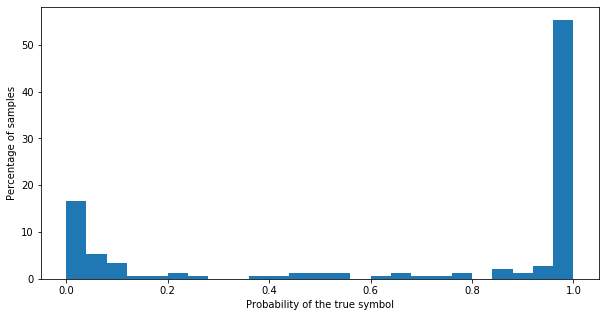

Histogram of highest assgined probability while processing each of symbols:


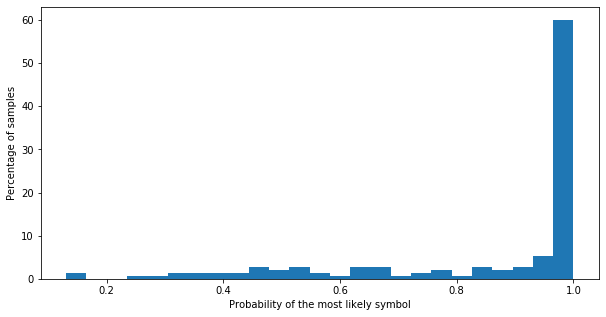

In [ ]:
double_pixelcnn_rec_l_tester.summary()

### Bidirectional PixelCNN + WaveNet

In [ ]:
pixelcnn_wavenet = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'lr': {
                                            'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                                'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                                'num_levels': 16
                                            },
                                            'n_layers': 7,
                                        },
                                        'rl': {
                                            'class_name': 'distsup.modules.reconstructors.RightToLeftReconstructor',
                                            'wrapped_class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                            'wave_net': {
                                                'class_name': 'distsup.modules.wavenet.WaveNet',
                                            },
                                            'num_layers': 10,
                                            'quantizer': {
                                              'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                              'num_levels': 16
                                            }
                                        }
                                   },
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_pixelcnn_wavenet_2019-12-17_17:50:15.pkl'
checkpoint = torch.load(model_serialize_path)
pixelcnn_wavenet.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
pixelcnn_wavenet_trainer = ReconstructorTrainer(pixelcnn_wavenet, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_pixelcnn_wavenet",
               serialize_epochs=50,
               serialize_sample=None)

In [ ]:
pixelcnn_wavenet_optim = optim.Adam(pixelcnn_wavenet.parameters(), lr=1e-4)

In [ ]:
ml_monitor.set_training("Scribblelens_PixelCNN_WaveNet")

In [ ]:
pixelcnn_wavenet_losses = pixelcnn_wavenet_trainer.train(pixelcnn_wavenet_optim, 50)

Train Epoch: 1 [0/3852 (0%)]	Loss: 0.854471
Train Epoch: 1 [3200/3852 (83%)]	Loss: 0.792809
Train Epoch: 2 [0/3852 (0%)]	Loss: 0.814995
Train Epoch: 2 [3200/3852 (83%)]	Loss: 0.817488
Train Epoch: 3 [0/3852 (0%)]	Loss: 0.878494
Train Epoch: 3 [3200/3852 (83%)]	Loss: 0.799054
Train Epoch: 4 [0/3852 (0%)]	Loss: 0.910752
Train Epoch: 4 [3200/3852 (83%)]	Loss: 0.805873
Train Epoch: 5 [0/3852 (0%)]	Loss: 0.804684
Train Epoch: 5 [3200/3852 (83%)]	Loss: 0.765788
Train Epoch: 6 [0/3852 (0%)]	Loss: 0.747142
Train Epoch: 6 [3200/3852 (83%)]	Loss: 0.815352
Train Epoch: 7 [0/3852 (0%)]	Loss: 0.807905
Train Epoch: 7 [3200/3852 (83%)]	Loss: 0.849031
Train Epoch: 8 [0/3852 (0%)]	Loss: 0.742425
Train Epoch: 8 [3200/3852 (83%)]	Loss: 0.844925
Train Epoch: 9 [0/3852 (0%)]	Loss: 0.815054
Train Epoch: 9 [3200/3852 (83%)]	Loss: 0.822294
Train Epoch: 10 [0/3852 (0%)]	Loss: 0.804511
Train Epoch: 10 [3200/3852 (83%)]	Loss: 0.728708
Train Epoch: 11 [0/3852 (0%)]	Loss: 0.843257
Train Epoch: 11 [3200/3852 (83%)]

In [ ]:
pixelcnn_wavenet_trainer.serialize(125, pixelcnn_wavenet_optim)

Model serialized as /content/drive/My Drive/master_thesis/models/Scribblelens_pixelcnn_wavenet_2019-12-17_17:50:15.pkl


In [ ]:
pixelcnn_wavenet_tester = ModelAlignmentCoincidentTester(pixelcnn_wavenet, scribblelens_test_loader)

In [ ]:
pixelcnn_wavenet_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 170 (0.57%)          	Miscalssified: 130 (0.43%)
Average probability assigned to the true symbol was: 0.55
Average probability assigned to the true symbol, when classified correctly was: 0.94
Average probability of most likely symbol while misclassifying was: 0.81
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 10
  '*': 5
  Z: 1
  a: 10
  b: 2
  c: 4
  d: 11
  e: 38
  g: 3
  h: 6
  i: 4
  j: 2
  k: 3
  l: 7
  m: 3
  n: 15
  o: 9
  p: 3
  r: 9
  s: 4
  t: 12
  u: 2
  v: 3
  w: 1
  y: 1
  z: 1
  "\xB4": 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 32
  '*': 8
  ',': 3
  W: 2
  a: 2
  b: 2
  c: 4
  d: 6
  e: 13
  f: 1
  g: 3
  i: 9
  j: 1
  k: 1
  l: 4
  m: 2
  n: 12
  o: 2
  p: 1
  r: 2
  s: 4
  t: 6
  u: 3
  v: 1
  x: 1
  y: 1
  z: 3
  "\xB4": 1

When classifying symbol * it's avg probability was: 0.382064460909414
When classifying symbol o it's avg probability was: 0

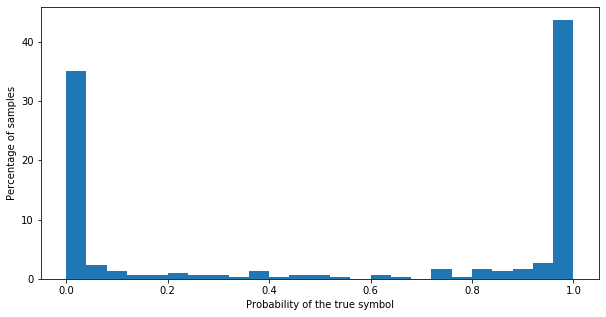

Histogram of highest assgined probability while processing each of symbols:


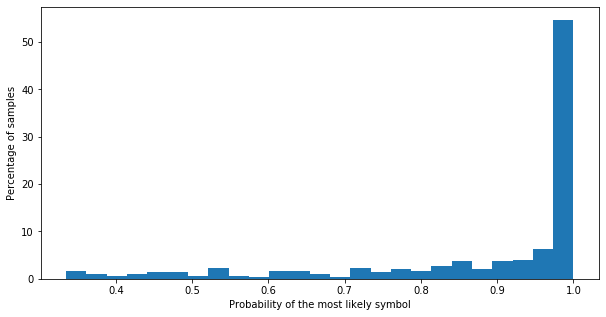

In [ ]:
pixelcnn_wavenet_tester.summary()

### Bidirectional WaveNet + PixelCNN

In [ ]:
wavenet_pixelcnn = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'lr': {
                                            'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                            'wave_net': {
                                                'class_name': 'distsup.modules.wavenet.WaveNet',
                                            },
                                            'num_layers': 10,
                                            'quantizer': {
                                              'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                              'num_levels': 16
                                            }
                                        },
                                       'rl': {
                                            'class_name': 'distsup.modules.reconstructors.RightToLeftReconstructor',
                                            'wrapped_class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                                'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                                'num_levels': 16
                                            },
                                            'n_layers': 7,
                                        },
                                   },
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_wavenet_pixelcnn_2019-12-17_18:57:00.pkl'
checkpoint = torch.load(model_serialize_path)
wavenet_pixelcnn.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
wavenet_pixelcnn_trainer = ReconstructorTrainer(wavenet_pixelcnn, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_wavenet_pixelcnn",
               serialize_epochs=50,
               serialize_sample=None)

In [ ]:
wavenet_pixelcnn_optim = optim.Adam(wavenet_pixelcnn.parameters(), lr=1e-3)

In [ ]:
ml_monitor.set_training("Scribblelens_WaveNet_PixelCNN")

In [ ]:
wavenet_pixelcnn_losses = wavenet_pixelcnn_trainer.train(wavenet_pixelcnn_optim, 30)

Train Epoch: 1 [0/3852 (0%)]	Loss: 0.886157
Train Epoch: 1 [3200/3852 (83%)]	Loss: 0.832774
Train Epoch: 2 [0/3852 (0%)]	Loss: 0.958390
Train Epoch: 2 [3200/3852 (83%)]	Loss: 0.855713
Train Epoch: 3 [0/3852 (0%)]	Loss: 0.854635
Train Epoch: 3 [3200/3852 (83%)]	Loss: 0.886079
Train Epoch: 4 [0/3852 (0%)]	Loss: 0.830054
Train Epoch: 4 [3200/3852 (83%)]	Loss: 0.831611
Train Epoch: 5 [0/3852 (0%)]	Loss: 0.866568
Train Epoch: 5 [3200/3852 (83%)]	Loss: 0.835064
Train Epoch: 6 [0/3852 (0%)]	Loss: 0.843390
Train Epoch: 6 [3200/3852 (83%)]	Loss: 0.834018
Train Epoch: 7 [0/3852 (0%)]	Loss: 0.896024
Train Epoch: 7 [3200/3852 (83%)]	Loss: 0.826288
Train Epoch: 8 [0/3852 (0%)]	Loss: 0.828784
Train Epoch: 8 [3200/3852 (83%)]	Loss: 0.884080
Train Epoch: 9 [0/3852 (0%)]	Loss: 0.921661
Train Epoch: 9 [3200/3852 (83%)]	Loss: 0.876380
Train Epoch: 10 [0/3852 (0%)]	Loss: 0.910931
Train Epoch: 10 [3200/3852 (83%)]	Loss: 0.867997
Train Epoch: 11 [0/3852 (0%)]	Loss: 0.891916
Train Epoch: 11 [3200/3852 (83%)]

In [ ]:
wavenet_pixelcnn_trainer.serialize(80, wavenet_pixelcnn_optim)

Model serialized as /content/drive/My Drive/master_thesis/models/Scribblelens_wavenet_pixelcnn_2019-12-17_18:57:00.pkl


In [ ]:
wavenet_pixelcnn_tester = ModelAlignmentCoincidentTester(wavenet_pixelcnn, scribblelens_test_loader)

In [ ]:
wavenet_pixelcnn_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 177 (0.59%)          	Miscalssified: 123 (0.41%)
Average probability assigned to the true symbol was: 0.58
Average probability assigned to the true symbol, when classified correctly was: 0.95
Average probability of most likely symbol while misclassifying was: 0.79
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 9
  '*': 9
  W: 1
  a: 11
  b: 2
  c: 4
  d: 9
  e: 43
  f: 1
  g: 6
  h: 3
  i: 4
  j: 1
  k: 4
  l: 6
  m: 4
  n: 11
  o: 7
  p: 4
  r: 9
  s: 4
  t: 13
  u: 4
  v: 4
  w: 1
  z: 2
  "\xB4": 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 33
  '*': 4
  ',': 3
  W: 1
  Z: 1
  a: 1
  b: 2
  c: 4
  d: 8
  e: 8
  h: 3
  i: 9
  j: 2
  l: 5
  m: 1
  n: 16
  o: 4
  r: 2
  s: 4
  t: 5
  u: 1
  x: 1
  y: 2
  z: 2
  "\xB4": 1

When classifying symbol * it's avg probability was: 0.6491638157100353
When classifying symbol o it's avg probability was: 0.6367494759011937
When 

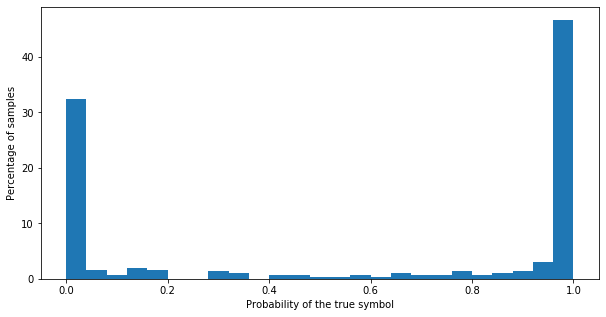

Histogram of highest assgined probability while processing each of symbols:


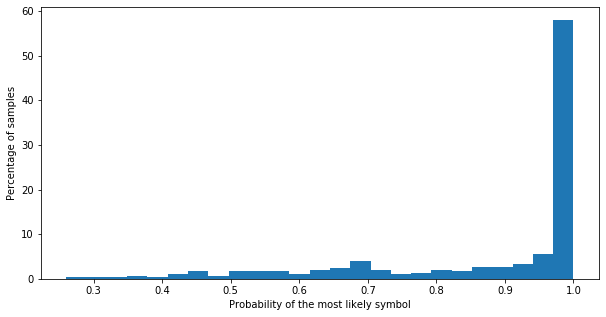

In [ ]:
wavenet_pixelcnn_tester.summary()

### Bidirectional WaveNet + WaveNet

In [ ]:
wavenet_wavenet = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'lr': {
                                            'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                            'wave_net': {
                                                'class_name': 'distsup.modules.wavenet.WaveNet',
                                            },
                                            'num_layers': 10,
                                            'quantizer': {
                                              'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                              'num_levels': 16
                                            }
                                        },
                                       'rl': {
                                            'class_name': 'distsup.modules.reconstructors.RightToLeftReconstructor',
                                            'wrapped_class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                            'wave_net': {
                                                'class_name': 'distsup.modules.wavenet.WaveNet',
                                            },
                                            'num_layers': 10,
                                            'quantizer': {
                                              'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                              'num_levels': 16
                                            }
                                        }
                                   },
                                   count_blanks_alignment=False,
                                   )

In [ ]:
model_serialize_path = '/content/drive/My Drive/master_thesis/models/Scribblelens_wavenet_wavenet_2019-12-17_19:43:57.pkl'
checkpoint = torch.load(model_serialize_path)
wavenet_wavenet.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
wavenet_wavenet_trainer = ReconstructorTrainer(wavenet_wavenet, chunked_tasman_loader,
               serialization_path=None,
               serialization_filename="Scribblelens_wavenet_wavenet",
               serialize_epochs=50,
               serialize_sample=None)

In [ ]:
wavenet_wavenet_optim = optim.Adam(wavenet_wavenet.parameters(), lr=1e-3)

In [ ]:
ml_monitor.set_training("Scribblelens_WaveNet_WaveNet")

In [ ]:
wavenet_wavenet_losses = wavenet_wavenet_trainer.train(wavenet_wavenet_optim, 75)

Train Epoch: 1 [0/3852 (0%)]	Loss: 5.549820
Train Epoch: 1 [3200/3852 (83%)]	Loss: 1.627556
Train Epoch: 2 [0/3852 (0%)]	Loss: 1.548434
Train Epoch: 2 [3200/3852 (83%)]	Loss: 1.293133
Train Epoch: 3 [0/3852 (0%)]	Loss: 1.496431
Train Epoch: 3 [3200/3852 (83%)]	Loss: 1.399762
Train Epoch: 4 [0/3852 (0%)]	Loss: 1.445846
Train Epoch: 4 [3200/3852 (83%)]	Loss: 1.281786
Train Epoch: 5 [0/3852 (0%)]	Loss: 1.387361
Train Epoch: 5 [3200/3852 (83%)]	Loss: 1.259459
Train Epoch: 6 [0/3852 (0%)]	Loss: 1.284537
Train Epoch: 6 [3200/3852 (83%)]	Loss: 1.131592
Train Epoch: 7 [0/3852 (0%)]	Loss: 1.259843
Train Epoch: 7 [3200/3852 (83%)]	Loss: 1.124379
Train Epoch: 8 [0/3852 (0%)]	Loss: 1.193633
Train Epoch: 8 [3200/3852 (83%)]	Loss: 1.226281
Train Epoch: 9 [0/3852 (0%)]	Loss: 1.180859
Train Epoch: 9 [3200/3852 (83%)]	Loss: 1.153730
Train Epoch: 10 [0/3852 (0%)]	Loss: 1.145988
Train Epoch: 10 [3200/3852 (83%)]	Loss: 1.143252
Train Epoch: 11 [0/3852 (0%)]	Loss: 1.003003
Train Epoch: 11 [3200/3852 (83%)]

In [ ]:
wavenet_wavenet_trainer.serialize(75, wavenet_wavenet_optim)

Model serialized as /content/drive/My Drive/master_thesis/models/Scribblelens_wavenet_wavenet_2019-12-17_19:43:57.pkl


In [ ]:
wavenet_wavenet_tester = ModelAlignmentCoincidentTester(wavenet_wavenet, scribblelens_test_loader)

In [ ]:
wavenet_wavenet_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 152 (0.51%)          	Miscalssified: 148 (0.49%)
Average probability assigned to the true symbol was: 0.51
Average probability assigned to the true symbol, when classified correctly was: 0.96
Average probability of most likely symbol while misclassifying was: 0.83
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 10
  '*': 6
  W: 1
  Z: 1
  a: 7
  b: 2
  c: 4
  d: 10
  e: 34
  g: 2
  h: 4
  i: 1
  j: 2
  k: 3
  l: 8
  m: 4
  n: 8
  o: 6
  p: 4
  r: 8
  s: 6
  t: 10
  u: 4
  v: 4
  w: 1
  y: 1
  z: 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 32
  '*': 7
  ',': 3
  W: 1
  a: 5
  b: 2
  c: 4
  d: 7
  e: 17
  f: 1
  g: 4
  h: 2
  i: 12
  j: 1
  k: 1
  l: 3
  m: 1
  n: 19
  o: 5
  r: 3
  s: 2
  t: 8
  u: 1
  x: 1
  y: 1
  z: 3
  "\xB4": 2

When classifying symbol * it's avg probability was: 0.4869889636935972
When classifying symbol o it's avg probability was: 0.52433902288

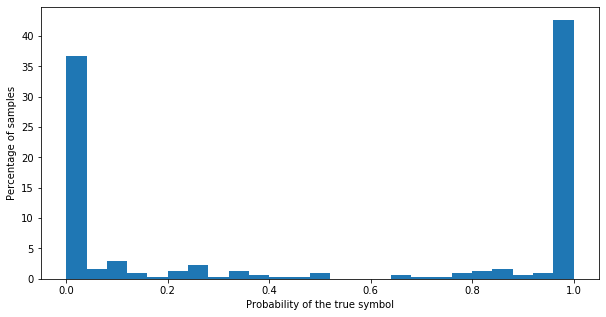

Histogram of highest assgined probability while processing each of symbols:


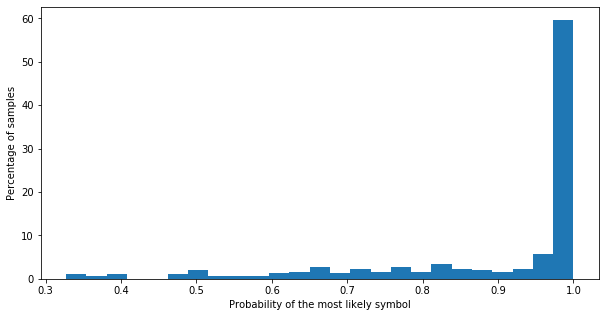

In [ ]:
wavenet_wavenet_tester.summary()

### Bidirectional splited

#### PixelCNN + PixelCNN

In [ ]:
rep_learner.reconstruction_loss(new_batch, (sample_test_cond_transformed, ), False)

(tensor(22.9768, device='cuda:0', grad_fn=<AddBackward0>),
 {'rec_loss': tensor(22.9768, device='cuda:0', grad_fn=<AddBackward0>),
  'rec_loss_per_pix': tensor(0.7180, device='cuda:0', grad_fn=<AddBackward0>),
  'rec_lr_loss': tensor(10.7079, device='cuda:0', grad_fn=<SumBackward0>),
  'rec_lr_loss_per_pix': tensor(0.3346, device='cuda:0', grad_fn=<DivBackward0>),
  'rec_rl_loss': tensor(12.2689, device='cuda:0', grad_fn=<SumBackward0>),
  'rec_rl_loss_per_pix': tensor(0.3834, device='cuda:0', grad_fn=<DivBackward0>)},
 [],
 [])

In [ ]:
mock_lr = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'lr': {
                                            'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                                'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                                'num_levels': 16
                                            },
                                            'n_layers': 7,
                                        },
                                        'rl': {
                                            'class_name': 'distsup.modules.reconstructors.RightToLeftReconstructor',
                                            'wrapped_class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                              'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                              'num_levels': 16
                                            },
                                            'n_layers': 7
                                        }
                                   },
                                   count_blanks_alignment=False,
                                   )

In [ ]:
mock_lr.reconstructors = nn.ModuleDict({"lr": double_pixelcnn_rec_l.reconstructors["lr"]})
mock_lr.reconstructor = double_pixelcnn_rec_l.reconstructors["lr"]

In [ ]:
double_pixelcnn_rec_l_lr_tester = ModelAlignmentCoincidentTester(mock_lr, scribblelens_test_loader)

In [ ]:
double_pixelcnn_rec_l_lr_tester.test_alignment_image_relation(100)

Classified samples: 100          	Classified correctly: 56 (0.56%)          	Miscalssified: 44 (0.44%)
Average probability assigned to the true symbol was: 0.58
Average probability assigned to the true symbol, when classified correctly was: 0.95
Average probability of most likely symbol while misclassifying was: 0.52
Symbols classified correctly: !!python/object/apply:collections.Counter
- '*': 2
  a: 4
  d: 3
  e: 17
  g: 3
  h: 1
  i: 1
  k: 2
  l: 3
  m: 2
  n: 3
  o: 2
  p: 2
  r: 4
  s: 1
  t: 3
  u: 1
  v: 2

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 12
  '*': 3
  ',': 1
  W: 1
  b: 1
  c: 1
  d: 1
  e: 3
  g: 1
  i: 2
  j: 1
  l: 1
  m: 1
  n: 5
  o: 1
  r: 1
  s: 3
  t: 3
  w: 1
  z: 1

When classifying symbol * it's avg probability was: 0.44178943783044816
When classifying symbol o it's avg probability was: 0.636142464975516
When classifying symbol r it's avg probability was: 0.7896608458366245
When classifying symbol e it's avg probability was

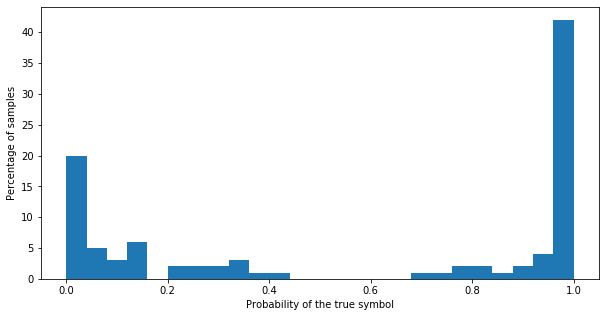

Histogram of highest assgined probability while processing each of symbols:


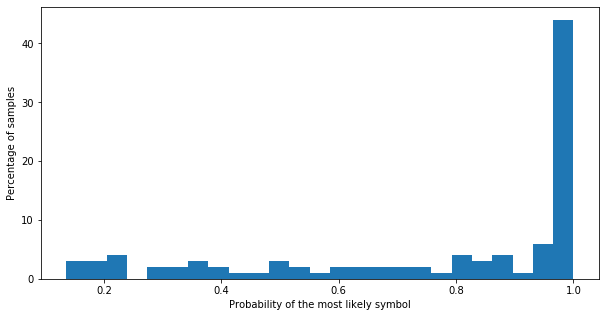

In [ ]:
double_pixelcnn_rec_l_lr_tester.summary()

#### Right-to-left

In [ ]:
mock_rl = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'lr': {
                                            'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                                'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                                'num_levels': 16
                                            },
                                            'n_layers': 7,
                                        },
                                        'rl': {
                                            'class_name': 'distsup.modules.reconstructors.RightToLeftReconstructor',
                                            'wrapped_class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                              'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                              'num_levels': 16
                                            },
                                            'n_layers': 7
                                        }
                                   },
                                   count_blanks_alignment=False,
                                   )

In [ ]:
mock_rl.reconstructors = nn.ModuleDict({"rl": double_pixelcnn_rec_l.reconstructors["rl"]})
mock_rl.reconstructor =double_pixelcnn_rec_l.reconstructors["rl"]

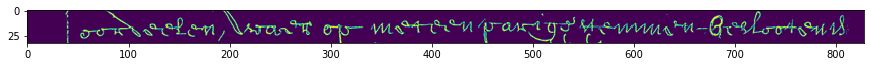

In [ ]:
plt.figure(figsize=(15,15))
rl_tar = mock_rl.reconstructor.get_inputs_and_targets(sample_test_img[None,:])[1]
rl_tar_flip = torch.flip(rl_tar, dims=(1,))
plt.imshow(rl_tar_flip.squeeze().transpose(0,1))

In [ ]:
double_pixelcnn_rec_l_rl_tester = ModelAlignmentCoincidentTester(mock_rl, scribblelens_test_loader)

In [ ]:
double_pixelcnn_rec_l_rl_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 139 (0.46%)          	Miscalssified: 161 (0.54%)
Average probability assigned to the true symbol was: 0.40
Average probability assigned to the true symbol, when classified correctly was: 0.80
Average probability of most likely symbol while misclassifying was: 0.51
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 4
  '*': 2
  ',': 1
  a: 2
  b: 1
  c: 4
  d: 9
  e: 35
  g: 5
  h: 5
  i: 4
  j: 1
  k: 2
  l: 8
  m: 3
  n: 13
  o: 5
  p: 3
  r: 7
  s: 3
  t: 11
  u: 4
  v: 3
  w: 1
  y: 2
  "\xB4": 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 38
  '*': 11
  ',': 2
  W: 2
  Z: 1
  a: 10
  b: 3
  c: 4
  d: 8
  e: 16
  f: 1
  g: 1
  h: 1
  i: 9
  j: 2
  k: 2
  l: 3
  m: 2
  n: 14
  o: 6
  p: 1
  r: 4
  s: 5
  t: 7
  u: 1
  v: 1
  x: 1
  z: 4
  "\xB4": 1

When classifying symbol o it's avg probability was: 0.38502760510891676
When classifying symbol d it's avg probability was

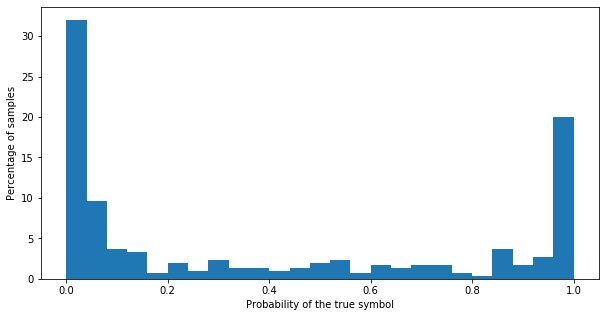

Histogram of highest assgined probability while processing each of symbols:


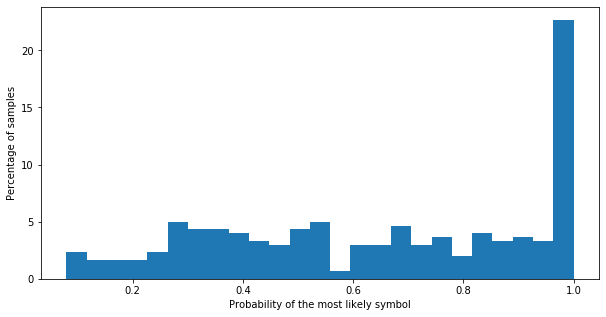

In [ ]:
double_pixelcnn_rec_l_rl_tester.summary()

#### PixelCNN + WaveNet

In [ ]:
mock_lr.reconstructors = nn.ModuleDict({"lr": pixelcnn_wavenet.reconstructors["lr"]})
mock_lr.reconstructor = pixelcnn_wavenet.reconstructors["lr"]

In [ ]:
pixelcnn_wavenet_lr_tester = ModelAlignmentCoincidentTester(mock_lr, scribblelens_test_loader)

In [ ]:
pixelcnn_wavenet_lr_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 172 (0.57%)          	Miscalssified: 128 (0.43%)
Average probability assigned to the true symbol was: 0.55
Average probability assigned to the true symbol, when classified correctly was: 0.88
Average probability of most likely symbol while misclassifying was: 0.53
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 5
  '*': 5
  W: 1
  Z: 1
  a: 8
  b: 2
  c: 5
  d: 9
  e: 41
  g: 5
  h: 6
  i: 5
  j: 2
  k: 4
  l: 8
  m: 3
  n: 13
  o: 7
  p: 3
  r: 9
  s: 4
  t: 12
  u: 5
  v: 4
  w: 1
  y: 1
  z: 2
  "\xB4": 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 37
  '*': 8
  ',': 3
  W: 1
  a: 4
  b: 2
  c: 3
  d: 8
  e: 10
  f: 1
  g: 1
  i: 8
  j: 1
  l: 3
  m: 2
  n: 14
  o: 4
  p: 1
  r: 2
  s: 4
  t: 6
  x: 1
  y: 1
  z: 2
  "\xB4": 1

When classifying symbol * it's avg probability was: 0.3426890798106727
When classifying symbol o it's avg probability was: 0.525919865478168

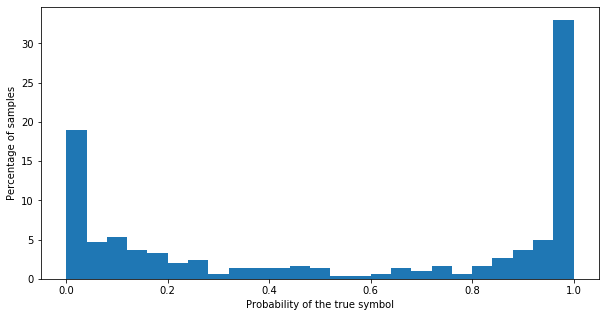

Histogram of highest assgined probability while processing each of symbols:


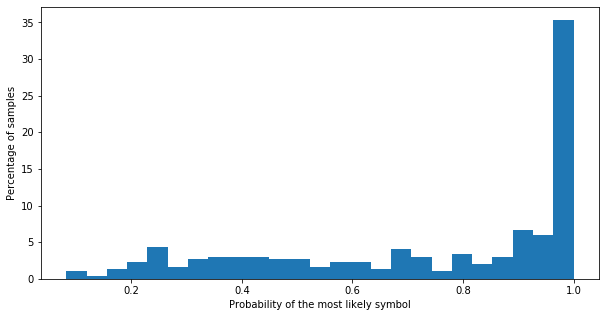

In [ ]:
pixelcnn_wavenet_lr_tester.summary()

In [ ]:
mock_rl.reconstructors = nn.ModuleDict({"rl": pixelcnn_wavenet.reconstructors["rl"]})
mock_rl.reconstructor = pixelcnn_wavenet.reconstructors["rl"]

In [ ]:
pixelcnn_wavenet_rl_tester = ModelAlignmentCoincidentTester(mock_rl, scribblelens_test_loader)

In [ ]:
pixelcnn_wavenet_rl_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 88 (0.29%)          	Miscalssified: 212 (0.71%)
Average probability assigned to the true symbol was: 0.28
Average probability assigned to the true symbol, when classified correctly was: 0.86
Average probability of most likely symbol while misclassifying was: 0.74
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 7
  '*': 3
  a: 3
  c: 2
  d: 8
  e: 23
  g: 1
  h: 3
  i: 1
  j: 1
  k: 2
  l: 3
  m: 2
  n: 4
  o: 5
  p: 3
  r: 6
  s: 1
  t: 6
  u: 1
  v: 2
  "\xB4": 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 35
  '*': 10
  ',': 3
  W: 2
  Z: 1
  a: 9
  b: 4
  c: 6
  d: 9
  e: 28
  f: 1
  g: 5
  h: 3
  i: 12
  j: 2
  k: 2
  l: 8
  m: 3
  n: 23
  o: 6
  p: 1
  r: 5
  s: 7
  t: 12
  u: 4
  v: 2
  w: 1
  x: 1
  y: 2
  z: 4
  "\xB4": 1

When classifying symbol e it's avg probability was: 0.3757105158488344
When classifying symbol l it's avg probability was: 0.281163765379113

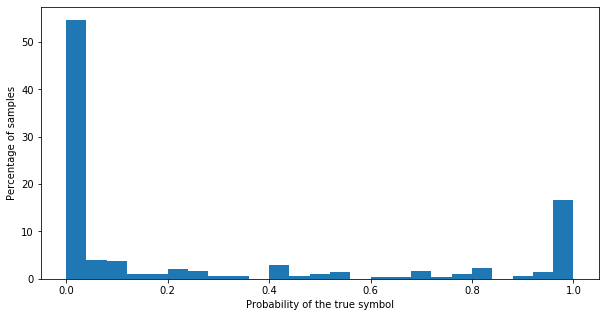

Histogram of highest assgined probability while processing each of symbols:


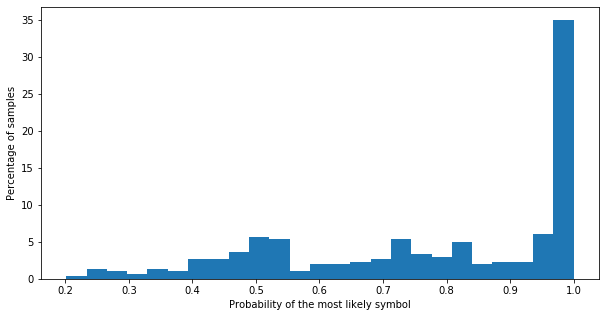

In [ ]:
pixelcnn_wavenet_rl_tester.summary()

#### WaveNet + PixelCNN

In [ ]:
mock_lr.reconstructors = nn.ModuleDict({"lr": wavenet_pixelcnn.reconstructors["lr"]})
mock_lr.reconstructor = wavenet_pixelcnn.reconstructors["lr"]

In [ ]:
wavenet_pixelcnn_lr_tester = ModelAlignmentCoincidentTester(mock_lr, scribblelens_test_loader)

In [ ]:
wavenet_pixelcnn_lr_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 118 (0.39%)          	Miscalssified: 182 (0.61%)
Average probability assigned to the true symbol was: 0.39
Average probability assigned to the true symbol, when classified correctly was: 0.91
Average probability of most likely symbol while misclassifying was: 0.75
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 8
  '*': 6
  a: 9
  b: 2
  d: 7
  e: 33
  f: 1
  g: 3
  h: 2
  i: 3
  k: 4
  l: 5
  m: 2
  n: 6
  o: 5
  p: 2
  r: 6
  s: 1
  t: 6
  u: 2
  v: 3
  w: 1
  z: 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 34
  '*': 7
  ',': 3
  W: 2
  Z: 1
  a: 3
  b: 2
  c: 8
  d: 10
  e: 18
  g: 3
  h: 4
  i: 10
  j: 3
  l: 6
  m: 3
  n: 21
  o: 6
  p: 2
  r: 5
  s: 7
  t: 12
  u: 3
  v: 1
  x: 1
  y: 2
  z: 3
  "\xB4": 2

When classifying symbol * it's avg probability was: 0.46888455759125647
When classifying symbol o it's avg probability was: 0.3969965753231835
When classifyin

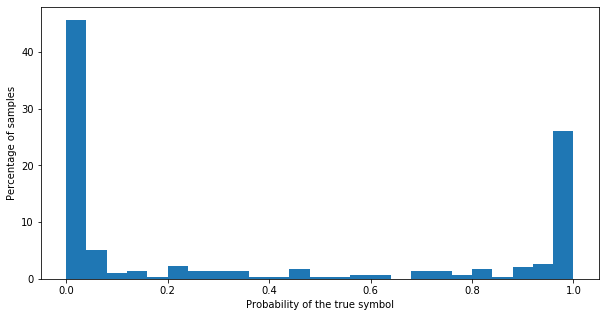

Histogram of highest assgined probability while processing each of symbols:


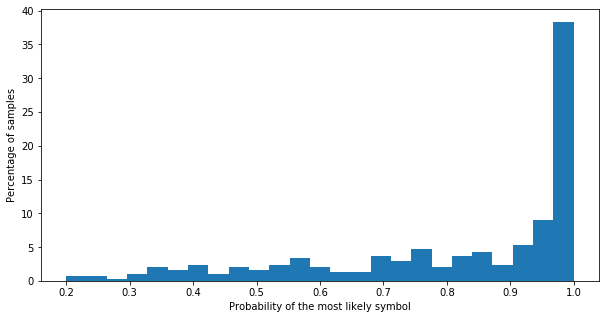

In [ ]:
wavenet_pixelcnn_lr_tester.summary()

In [ ]:
mock_rl.reconstructors = nn.ModuleDict({"rl": wavenet_pixelcnn.reconstructors["rl"]})
mock_rl.reconstructor = wavenet_pixelcnn.reconstructors["rl"]

In [ ]:
wavenet_pixelcnn_rl_tester = ModelAlignmentCoincidentTester(mock_rl, scribblelens_test_loader)

In [ ]:
wavenet_pixelcnn_rl_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 140 (0.47%)          	Miscalssified: 160 (0.53%)
Average probability assigned to the true symbol was: 0.42
Average probability assigned to the true symbol, when classified correctly was: 0.81
Average probability of most likely symbol while misclassifying was: 0.50
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 5
  '*': 3
  Z: 1
  a: 7
  b: 1
  c: 5
  d: 9
  e: 32
  g: 4
  h: 5
  i: 5
  j: 2
  k: 1
  l: 5
  m: 4
  n: 12
  o: 5
  p: 3
  r: 9
  s: 3
  t: 10
  u: 3
  v: 3
  w: 1
  z: 1
  "\xB4": 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 37
  '*': 10
  ',': 3
  W: 2
  a: 5
  b: 3
  c: 3
  d: 8
  e: 19
  f: 1
  g: 2
  h: 1
  i: 8
  j: 1
  k: 3
  l: 6
  m: 1
  n: 15
  o: 6
  p: 1
  r: 2
  s: 5
  t: 8
  u: 2
  v: 1
  x: 1
  y: 2
  z: 3
  "\xB4": 1

When classifying symbol o it's avg probability was: 0.4160677502778443
When classifying symbol r it's avg probability was: 0.

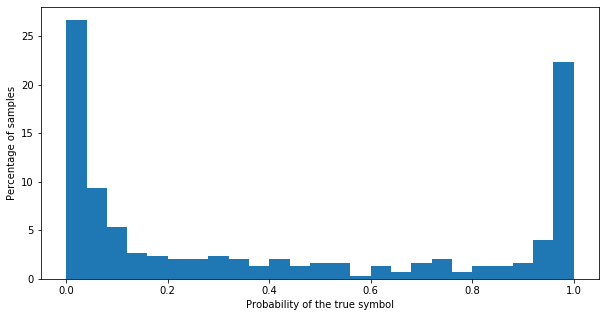

Histogram of highest assgined probability while processing each of symbols:


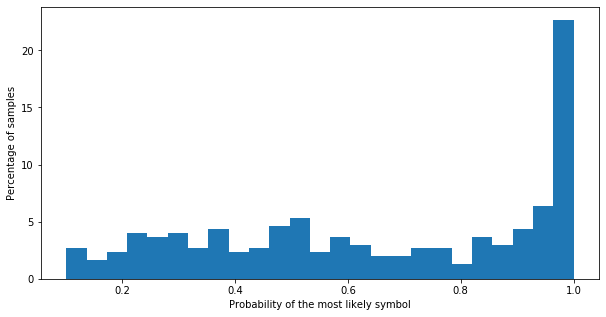

In [ ]:
wavenet_pixelcnn_rl_tester.summary()

#### WaveNet + WaveNet

In [ ]:
mock_lr.reconstructors = nn.ModuleDict({"lr": wavenet_wavenet.reconstructors["lr"]})
mock_lr.reconstructor = wavenet_wavenet.reconstructors["lr"]

In [ ]:
wavenet_wavenet_lr_tester = ModelAlignmentCoincidentTester(mock_lr, scribblelens_test_loader)

In [ ]:
wavenet_wavenet_lr_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 128 (0.43%)          	Miscalssified: 172 (0.57%)
Average probability assigned to the true symbol was: 0.41
Average probability assigned to the true symbol, when classified correctly was: 0.90
Average probability of most likely symbol while misclassifying was: 0.75
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 10
  '*': 5
  W: 2
  Z: 1
  a: 5
  b: 1
  c: 2
  d: 5
  e: 37
  g: 3
  h: 3
  i: 2
  j: 1
  k: 2
  l: 6
  m: 2
  n: 8
  o: 2
  p: 3
  r: 7
  s: 3
  t: 8
  u: 4
  v: 3
  w: 1
  y: 1
  z: 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 32
  '*': 8
  ',': 3
  a: 7
  b: 3
  c: 6
  d: 12
  e: 14
  f: 1
  g: 3
  h: 3
  i: 11
  j: 2
  k: 2
  l: 5
  m: 3
  n: 19
  o: 9
  p: 1
  r: 4
  s: 5
  t: 10
  u: 1
  v: 1
  x: 1
  y: 1
  z: 3
  "\xB4": 2

When classifying symbol e it's avg probability was: 0.7031574920336745
When classifying symbol l it's avg probability was: 0.4858

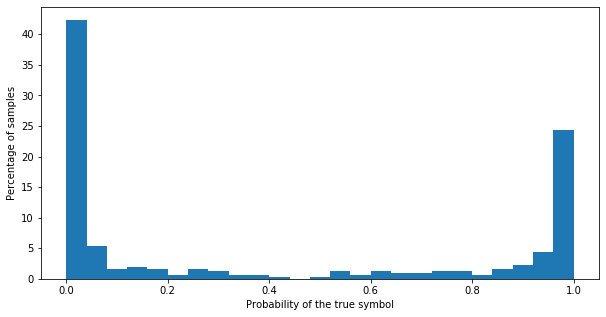

Histogram of highest assgined probability while processing each of symbols:


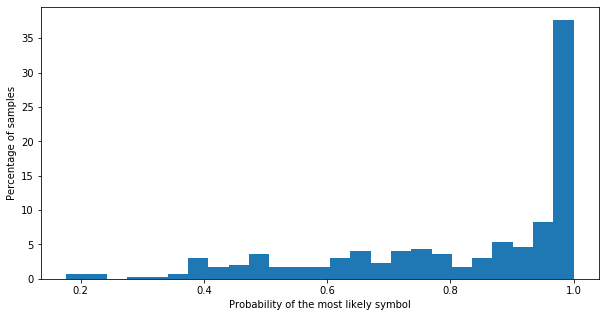

In [ ]:
wavenet_wavenet_lr_tester.summary()

In [ ]:
mock_rl.reconstructors = nn.ModuleDict({"rl": wavenet_wavenet.reconstructors["rl"]})
mock_rl.reconstructor = wavenet_wavenet.reconstructors["rl"]

In [ ]:
wavenet_wavenet_rl_tester = ModelAlignmentCoincidentTester(mock_rl, scribblelens_test_loader)

In [ ]:
wavenet_wavenet_rl_tester.test_alignment_image_relation(300)

Classified samples: 300          	Classified correctly: 76 (0.25%)          	Miscalssified: 224 (0.75%)
Average probability assigned to the true symbol was: 0.25
Average probability assigned to the true symbol, when classified correctly was: 0.86
Average probability of most likely symbol while misclassifying was: 0.72
Symbols classified correctly: !!python/object/apply:collections.Counter
- ' ': 3
  '*': 2
  W: 1
  a: 1
  b: 1
  c: 1
  d: 7
  e: 16
  g: 1
  h: 4
  i: 1
  j: 1
  k: 1
  l: 2
  m: 3
  n: 4
  o: 3
  p: 3
  r: 7
  s: 1
  t: 6
  u: 1
  v: 3
  w: 1
  y: 1
  z: 1

Symbols classified badly: !!python/object/apply:collections.Counter
- ' ': 39
  '*': 11
  ',': 3
  W: 1
  Z: 1
  a: 11
  b: 3
  c: 7
  d: 10
  e: 35
  f: 1
  g: 5
  h: 2
  i: 12
  j: 2
  k: 3
  l: 9
  m: 2
  n: 23
  o: 8
  p: 1
  r: 4
  s: 7
  t: 12
  u: 4
  v: 1
  x: 1
  y: 1
  z: 3
  "\xB4": 2

When classifying symbol r it's avg probability was: 0.6420640357425665
When classifying symbol e it's avg probability was:

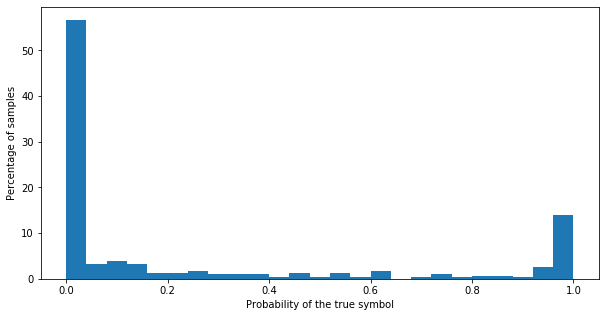

Histogram of highest assgined probability while processing each of symbols:


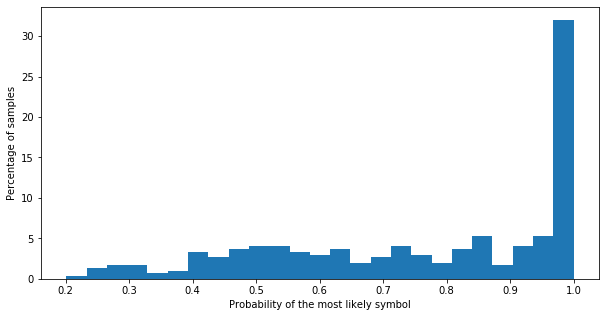

In [ ]:
wavenet_wavenet_rl_tester.summary()

##Alignment analysis

In [ ]:
sample_chunk_batch = next(iter(chunked_tasman_loader))

In [ ]:
sample_chunk_img = sample_chunk_batch["features"][0]
sample_chunk_cond = sample_chunk_batch["alignment"][0]

In [ ]:
reduced_align = wavenet_rec.transform_alignment(sample_test_cond.long()[None,:].to(device)).squeeze()

In [ ]:
reduced_align.transpose(0,1).shape

torch.Size([68, 207])

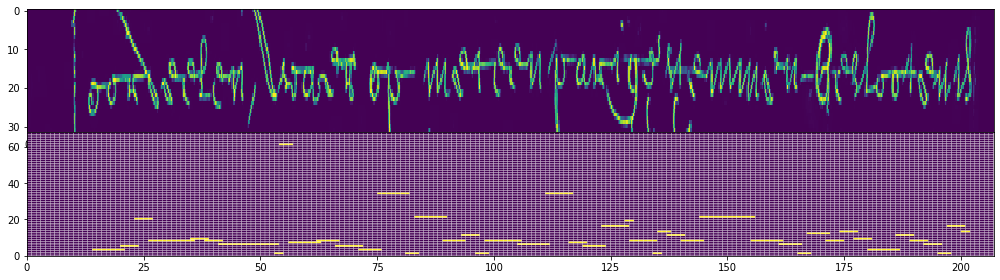

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(14,4))
axs[0].imshow(sample_test_img.squeeze().data.cpu().transpose(0,1), aspect="auto")
axs[1].pcolor(np.array(reduced_align.transpose(0,1).data.cpu()),edgecolors='w')
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show() 

In [ ]:
print(sample_test_batch["alignment_text"][0])

oordeelen Waerop met eenparige stemmen beslooten is


In [ ]:
_wavenet_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   len_reduction=2,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                       'wave_net': {
                                          'class_name': 'distsup.modules.wavenet.WaveNet',
                                       },
                                       'num_layers': 10,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   )

In [ ]:
_wavenet_rec.load_state_dict(wavenet_rec.state_dict())

<All keys matched successfully>

In [ ]:
_reduced_align = _wavenet_rec.transform_alignment(sample_test_cond.long()[None,:].to(device)).squeeze()

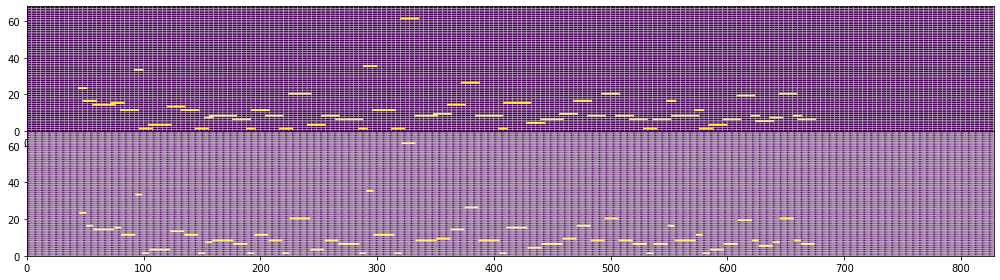

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(14,4))
axs[0].pcolor(np.array(reduced_align.transpose(0,1).data.cpu()),edgecolors='w')
axs[1].pcolor(np.array(_reduced_align.transpose(0,1).data.cpu()),edgecolors='w')
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

##Tests

In [ ]:
double_pixelcnn_rec_ltest = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'lr': {
                                            'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                                'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                                'num_levels': 16
                                            },
                                            'n_layers': 7,
                                        },
                                        'rl': {
                                            'class_name': 'distsup.modules.reconstructors.RightToLeftReconstructor',
                                            'wrapped_class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                              'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                              'num_levels': 16
                                            },
                                            'n_layers': 7
                                        }
                                   },
                                   count_blanks_alignment=False,
                                   )
double_pixelcnn_rec_ltest.load_state_dict(double_pixelcnn_rec_l.state_dict())

<All keys matched successfully>

In [ ]:
double_pixelcnn_rec_ltest.eval()

cum_out = None
lr_out = double_pixelcnn_rec_ltest.reconstructors["lr"](sample_test_img[None,:].to(device), (sample_test_cond_transformed,))
cum_out = lr_out
rl_out = double_pixelcnn_rec_ltest.reconstructors["rl"](sample_test_img[None,:].to(device), (sample_test_cond_transformed,))
cum_out += rl_out

In [ ]:
cum_out.shape

torch.Size([1, 828, 32, 1, 16])

In [ ]:
double_pixelcnn_rec_ltest.eval()
rec_out2 = double_pixelcnn_rec_ltest(sample_test_img[None,:].to(device), sample_test_cond.long()[None,:].to(device))

In [ ]:
rec_out["lr"].shape

torch.Size([1, 828, 32, 1, 16])

In [ ]:
torch.all(rec_out["lr"] + rec_out["rl"] == rec_out2)

tensor(True, device='cuda:0')

In [ ]:
rl_in, rl_tar = double_pixelcnn_rec_l2.reconstructors["rl"].get_inputs_and_targets(sample_test_img[None,:].to(device))

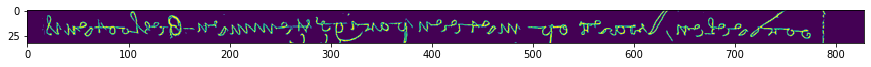

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(rl_in.squeeze().transpose(0,1).data.cpu())

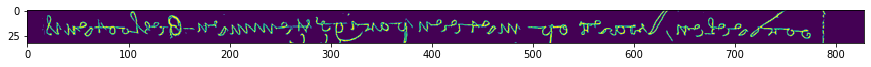

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(rl_tar.squeeze().transpose(0,1).data.cpu())

In [ ]:
next(iter(chunked_tasman_loader)).keys()

dict_keys(['item_dir', 'scribe', 'line_index', 'img_filename', 'scribe_id', 'alignment', 'alignment_text', 'text_filename', 'img_size', 'features', 'text_available'])

In [ ]:
double_pixelcnn_rec_l(sample_test_img[None,:].to(device), sample_test_cond.long()[None,:].to(device), return_dict=True)

{'lr': tensor([[[[[ 9.1572e+00, -1.4822e+00, -1.4498e+00,  ..., -2.2966e+00,
             -3.4011e+00, -4.9688e+00]],
 
           [[ 1.1553e+01, -2.8537e-01, -8.3028e-01,  ..., -6.3103e+00,
             -1.0583e+01, -1.5558e+01]],
 
           [[ 1.1525e+01, -1.3201e-01, -9.5728e-01,  ..., -7.0576e+00,
             -1.1839e+01, -1.7262e+01]],
 
           ...,
 
           [[ 1.1442e+01, -5.1510e-01, -1.1297e+00,  ..., -6.2776e+00,
             -1.1065e+01, -1.6786e+01]],
 
           [[ 1.2110e+01, -1.9988e-02, -5.8952e-01,  ..., -7.8107e+00,
             -1.3065e+01, -1.9124e+01]],
 
           [[ 1.1799e+01, -1.0766e-01, -9.2355e-01,  ..., -6.5625e+00,
             -1.0303e+01, -1.5006e+01]]],
 
 
          [[[ 1.2926e+01, -3.4484e-02, -8.3850e-01,  ..., -6.3809e+00,
             -1.0838e+01, -1.5665e+01]],
 
           [[ 1.8643e+01,  3.2292e+00,  1.6377e+00,  ..., -1.5890e+01,
             -2.3591e+01, -3.2461e+01]],
 
           [[ 1.8879e+01,  2.8298e+00,  1.4916e+00,  ..., -1.

In [ ]:
torch.flip(torch.flip(torch.tensor([[1,2,3],[4,5,6]]), dims=(1,)), dims=(1,))

tensor([[1, 2, 3],
        [4, 5, 6]])